In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set plotting style
plt.style.use('fivethirtyeight')
sns.set_palette('bright')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [4]:
## **DATA COLLECTION**

In [5]:
# 1. Data Loading
print("Loading IPL datasets...")
matches = pd.read_csv('matches.csv')
deliveries = pd.read_csv('deliveries.csv')

print(f"Matches dataset shape: {matches.shape}")
print(f"Deliveries dataset shape: {deliveries.shape}")

Loading IPL datasets...
Matches dataset shape: (1095, 20)
Deliveries dataset shape: (260920, 17)


In [119]:
# Display sample data with a pleasing style
print("\nSample data from matches dataset:")
matches.head().style.background_gradient(cmap='tab20').set_properties(
    **{'border': '1px solid #ddd', 'padding': '5px'}
)


Sample data from matches dataset:


,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.000000,223.000000,20.000000,N,nan,Asad Rauf,RE Koertzen
1,335983,2007/08,Chandigarh,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.000000,241.000000,20.000000,N,nan,MR Benson,SL Shastri
2,335984,2007/08,Delhi,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.000000,130.000000,20.000000,N,nan,Aleem Dar,GA Pratapkumar
3,335985,2007/08,Mumbai,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.000000,166.000000,20.000000,N,nan,SJ Davis,DJ Harper
4,335986,2007/08,Kolkata,2008-04-20,League,DJ Hussey,Eden Gardens,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.000000,111.000000,20.000000,N,nan,BF Bowden,K Hariharan


In [7]:
## **DATA PRE-PROCESSING**

In [8]:
### 2. Data Cleaning and Preprocessing
print("\nChecking for missing values in matches dataset:")
print(matches.isnull().sum())
# Handle missing values
matches['city'].fillna('Unknown', inplace=True)
matches['player_of_match'].fillna('Unknown', inplace=True)
matches['winner'].fillna('No Result', inplace=True)
matches['result_margin'].fillna(0, inplace=True)

# Standardize team names
team_name_mapping = {
    'Delhi Daredevils': 'Delhi Capitals',
    'Deccan Chargers': 'Sunrisers Hyderabad',
    'Rising Pune Supergiants': 'Rising Pune Supergiant',
    'Kings XI Punjab': 'Punjab Kings'
}

for old_name, new_name in team_name_mapping.items():
    matches['team1'] = matches['team1'].replace(old_name, new_name)
    matches['team2'] = matches['team2'].replace(old_name, new_name)
    matches['toss_winner'] = matches['toss_winner'].replace(old_name, new_name)
    matches['winner'] = matches['winner'].replace(old_name, new_name)
    
    deliveries['batting_team'] = deliveries['batting_team'].replace(old_name, new_name)
    deliveries['bowling_team'] = deliveries['bowling_team'].replace(old_name, new_name)

print("\nAfter cleaning, missing values in matches dataset:")
print(matches.isnull().sum())


Checking for missing values in matches dataset:
id                    0
season                0
city                 51
date                  0
match_type            0
player_of_match       5
venue                 0
team1                 0
team2                 0
toss_winner           0
toss_decision         0
winner                5
result                0
result_margin        19
target_runs           3
target_overs          3
super_over            0
method             1074
umpire1               0
umpire2               0
dtype: int64

After cleaning, missing values in matches dataset:
id                    0
season                0
city                  0
date                  0
match_type            0
player_of_match       0
venue                 0
team1                 0
team2                 0
toss_winner           0
toss_decision         0
winner                0
result                0
result_margin         0
target_runs           3
target_overs          3
super_over            

In [9]:
## **EXOPLORATORY DATA ANALYSIS (EDA)**


--------------------------------------- Team Performance Analysis ---------------------------------------

Team Performance:


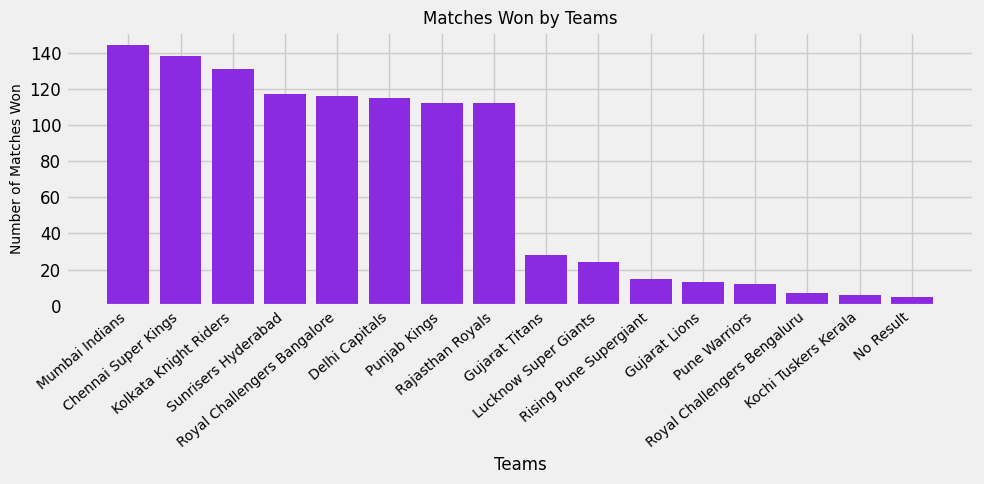

In [10]:
import jinja2

# 3.1 Team Performance Analysis
print("\n--------------------------------------- Team Performance Analysis ---------------------------------------")

# Matches played by each team
team1_counts = matches['team1'].value_counts()
team2_counts = matches['team2'].value_counts()
team_matches = team1_counts.add(team2_counts, fill_value=0).astype(int)

# Matches won by each team
team_wins = matches['winner'].value_counts()

# Create a dataframe for team performance
team_performance = pd.DataFrame({
    'Matches_Played': team_matches,
    'Matches_Won': team_wins
})

team_performance['Win_Percentage'] = round((team_performance['Matches_Won'] / team_performance['Matches_Played']) * 100, 2)
team_performance = team_performance.sort_values('Win_Percentage', ascending=False)

print("\nTeam Performance:")
# print(team_performance)
team_performance.style.background_gradient(cmap='gnuplot')


# Plot matches won by teams
plt.figure(figsize=(10, 5))
plt.bar(team_wins.index, team_wins.values, color='blueviolet')
plt.title('Matches Won by Teams', fontsize=12)
plt.xlabel('Teams', fontsize=12)
plt.ylabel('Number of Matches Won', fontsize=10)
plt.xticks(rotation=40, ha='right', fontsize=10)
plt.tight_layout()
plt.savefig('matches_won_by_teams.png')
plt.show()


Team Run Rates and Economy Rates (fixed):


<Figure size 1200x700 with 0 Axes>

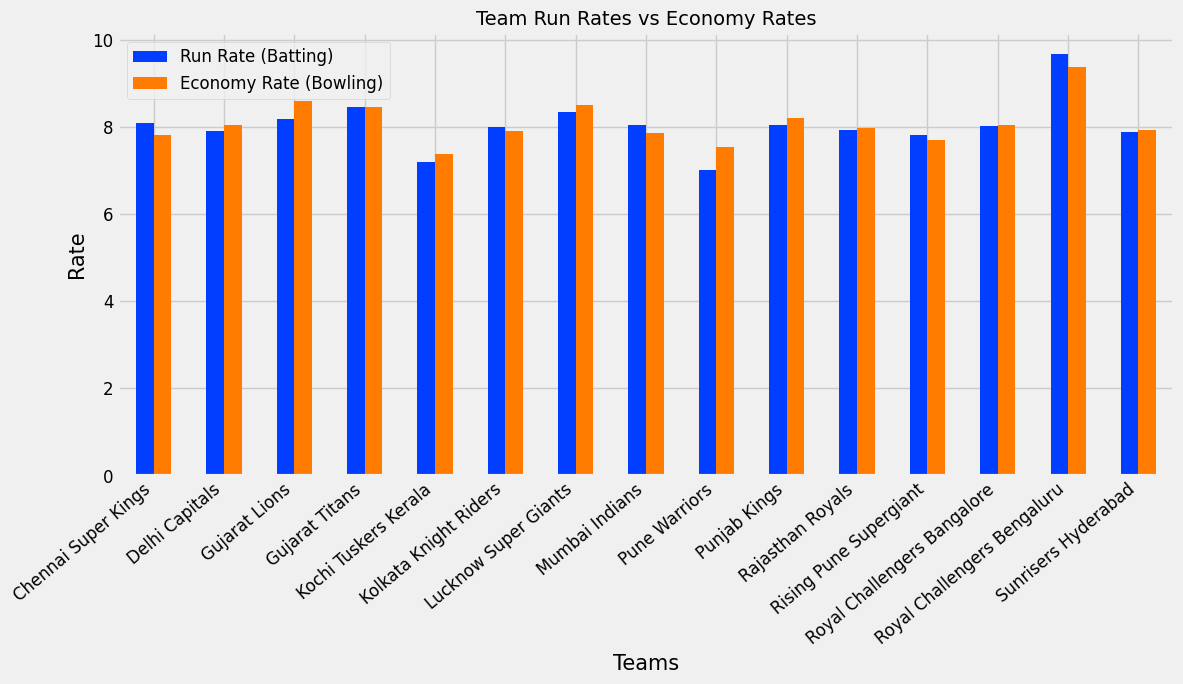

In [11]:
# Calculate run rates and economy rates
team_runs = {}
team_balls_faced = {}
team_runs_conceded = {}
team_balls_bowled = {}

for _, row in deliveries.iterrows():
    batting_team = row['batting_team']
    bowling_team = row['bowling_team']
    runs = row['total_runs']
    
    # Update batting stats
    if batting_team not in team_runs:
        team_runs[batting_team] = 0
        team_balls_faced[batting_team] = 0
    
    team_runs[batting_team] += runs
    team_balls_faced[batting_team] += 1
    
    # Update bowling stats
    if bowling_team not in team_runs_conceded:
        team_runs_conceded[bowling_team] = 0
        team_balls_bowled[bowling_team] = 0
    
    team_runs_conceded[bowling_team] += runs
    team_balls_bowled[bowling_team] += 1
    
# Calculate run rate and economy rate
teams_union = sorted(set(team_runs.keys()).union(set(team_runs_conceded.keys())))
team_stats = pd.DataFrame(index=teams_union)

team_stats['Run_Rate'] = pd.Series({
    team: (runs * 6 / team_balls_faced[team]) if team in team_balls_faced and team_balls_faced[team] else 0
    for team, runs in team_runs.items()
}).round(2)

team_stats['Economy_Rate'] = pd.Series({
    team: (runs * 6 / team_balls_bowled[team]) if team in team_balls_bowled and team_balls_bowled[team] else 0
    for team, runs in team_runs_conceded.items()
}).round(2)

print("\nTeam Run Rates and Economy Rates (fixed):")
# print(team_stats)
team_stats.style.background_gradient(cmap='ocean')

# Plot run rates and economy rates
plt.figure(figsize=(12, 7))
team_stats.plot(kind='bar', figsize=(12, 7))
plt.title('Team Run Rates vs Economy Rates', fontsize=14)
plt.xlabel('Teams', fontsize=15)
plt.ylabel('Rate', fontsize=15)
plt.xticks(rotation=40, ha='right')
plt.legend(['Run Rate (Batting)', 'Economy Rate (Bowling)'])
plt.tight_layout()
plt.savefig('team_run_rates_economy.png')
plt.show()

In [12]:

# Calculate highest and lowest scores for each team
team_highest_scores = {}
team_lowest_scores = {}

for match_id in matches['id'].unique():
    match_deliveries = deliveries[deliveries['match_id'] == match_id]
    batting_teams = match_deliveries['batting_team'].unique()
    
    for team in batting_teams:
        team_deliveries = match_deliveries[match_deliveries['batting_team'] == team]
        total_score = team_deliveries['total_runs'].sum()
        
        if team not in team_highest_scores or total_score > team_highest_scores[team]:
            team_highest_scores[team] = total_score
            
        if team not in team_lowest_scores or total_score < team_lowest_scores[team]:
            team_lowest_scores[team] = total_score

# Create dataframe for highest and lowest scores
team_scores = pd.DataFrame({
    'Highest_Score': pd.Series(team_highest_scores),
    'Lowest_Score': pd.Series(team_lowest_scores)
})

print("\nTeam Highest and Lowest Scores:")
team_scores.style.background_gradient(cmap='Greens')



Team Highest and Lowest Scores:


,Highest_Score,Lowest_Score
Kolkata Knight Riders,272,48
Royal Challengers Bangalore,263,2
Chennai Super Kings,246,55
Punjab Kings,262,68
Rajasthan Royals,226,41
Delhi Capitals,257,56
Mumbai Indians,247,68
Sunrisers Hyderabad,287,44
Kochi Tuskers Kerala,184,74
Pune Warriors,192,99


<Figure size 1000x600 with 0 Axes>

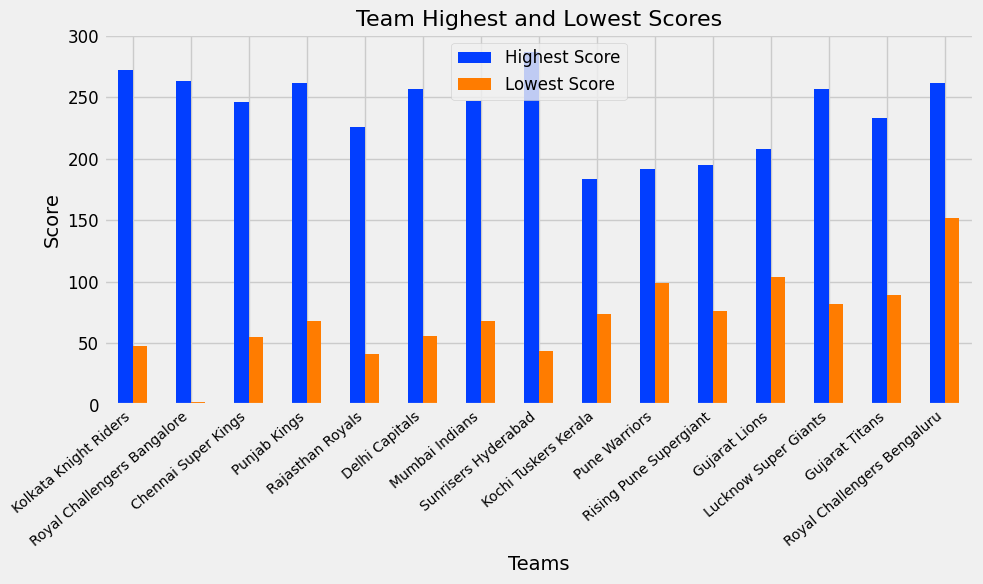

In [13]:

# Plot highest and lowest scores
plt.figure(figsize=(10, 6))
team_scores.plot(kind='bar', figsize=(10, 6))
plt.title('Team Highest and Lowest Scores', fontsize=16)
plt.xlabel('Teams', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(rotation=40, ha='right', fontsize=10)
plt.legend(['Highest Score', 'Lowest Score'])
plt.tight_layout()
plt.savefig('team_highest_lowest_scores.png')
plt.show()


In [14]:

# Calculate total 4s and 6s for each team
team_fours = {}
team_sixes = {}

for _, row in deliveries.iterrows():
    batting_team = row['batting_team']
    runs = row['batsman_runs']
    
    if batting_team not in team_fours:
        team_fours[batting_team] = 0
        team_sixes[batting_team] = 0
    
    if runs == 4:
        team_fours[batting_team] += 1
    elif runs == 6:
        team_sixes[batting_team] += 1

# Create dataframe for 4s and 6s
team_boundaries = pd.DataFrame({
    'Fours': pd.Series(team_fours),
    'Sixes': pd.Series(team_sixes)
})

print("\nTeam Boundaries (4s and 6s):")
team_boundaries.style.background_gradient(cmap='Spectral')



Team Boundaries (4s and 6s):


,Fours,Sixes
Kolkata Knight Riders,3461,1495
Royal Challengers Bangalore,3149,1488
Chennai Super Kings,3196,1509
Punjab Kings,3426,1515
Rajasthan Royals,3091,1237
Delhi Capitals,3508,1351
Mumbai Indians,3637,1685
Sunrisers Hyderabad,3362,1442
Kochi Tuskers Kerala,170,53
Pune Warriors,525,196


<Figure size 1000x600 with 0 Axes>

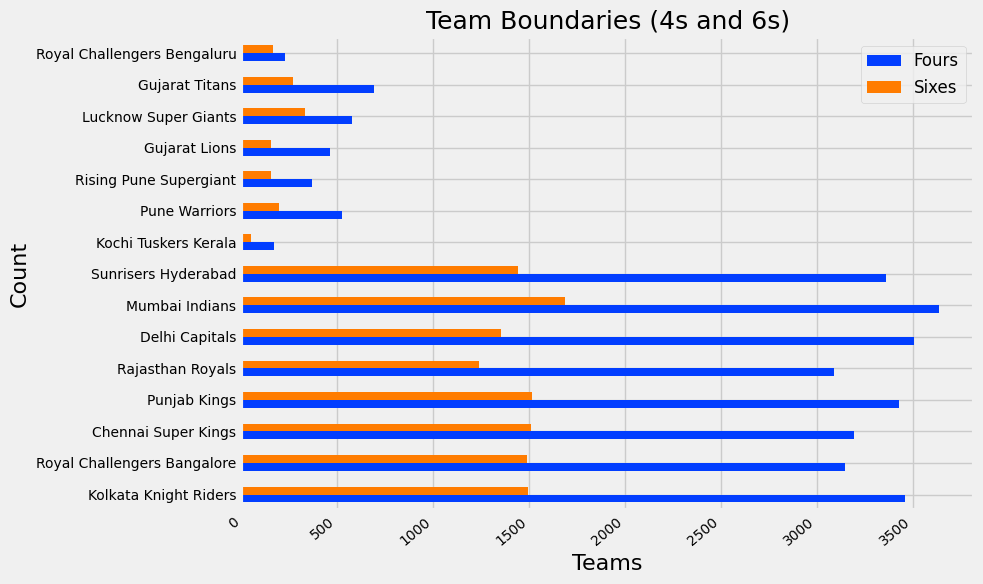


Team Average Powerplay and Death Overs Score:


<Figure size 1000x700 with 0 Axes>

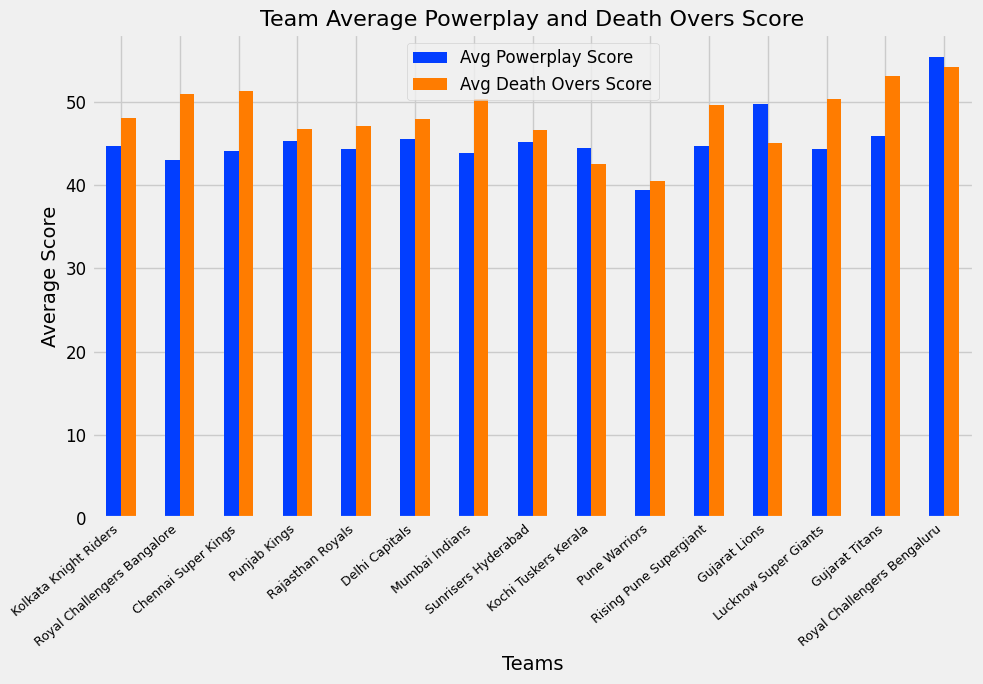

In [15]:

# Plot 4s and 6s
plt.figure(figsize=(10, 6))
team_boundaries.plot(kind='barh', figsize=(10, 6))
plt.title('Team Boundaries (4s and 6s)', fontsize=18)
plt.xlabel('Teams', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(rotation=40, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(['Fours', 'Sixes'])
plt.tight_layout()
plt.savefig('team_boundaries.png')
plt.show()

# Calculate powerplay and death overs scores
def is_powerplay(over):
    return over <= 6

def is_death_over(over):
    return over >= 16

team_powerplay_runs = {}
team_powerplay_balls = {}
team_death_runs = {}
team_death_balls = {}

for _, row in deliveries.iterrows():
    batting_team = row['batting_team']
    over = row['over']
    runs = row['total_runs']
    
    if batting_team not in team_powerplay_runs:
        team_powerplay_runs[batting_team] = 0
        team_powerplay_balls[batting_team] = 0
        team_death_runs[batting_team] = 0
        team_death_balls[batting_team] = 0
    
    if is_powerplay(over):
        team_powerplay_runs[batting_team] += runs
        team_powerplay_balls[batting_team] += 1
    
    if is_death_over(over):
        team_death_runs[batting_team] += runs
        team_death_balls[batting_team] += 1

# Calculate average powerplay and death overs score
team_phase_scores = pd.DataFrame(index=team_powerplay_runs.keys())
team_phase_scores['Avg_Powerplay_Score'] = pd.Series({team: (runs * 36 / balls) if balls > 0 else 0 
                                                    for team, runs, balls in zip(team_powerplay_runs.keys(), 
                                                                                team_powerplay_runs.values(), 
                                                                                team_powerplay_balls.values())}).round(2)
team_phase_scores['Avg_Death_Score'] = pd.Series({team: (runs * 30 / balls) if balls > 0 else 0 
                                                for team, runs, balls in zip(team_death_runs.keys(), 
                                                                            team_death_runs.values(), 
                                                                            team_death_balls.values())}).round(2)

print("\nTeam Average Powerplay and Death Overs Score:")
team_phase_scores.style.background_gradient(cmap='summer')
# Plot average powerplay and death overs score
plt.figure(figsize=(10, 7))
team_phase_scores.plot(kind='bar', figsize=(10, 7))
plt.title('Team Average Powerplay and Death Overs Score', fontsize=16)
plt.xlabel('Teams', fontsize=14)
plt.ylabel('Average Score', fontsize=14)
plt.xticks(rotation=40, ha='right', fontsize=9)
plt.legend(['Avg Powerplay Score', 'Avg Death Overs Score'])
plt.tight_layout()
plt.savefig('team_phase_scores.png')
plt.show()



--- Player Performance Analysis ---

Top 20 Run Scorers:


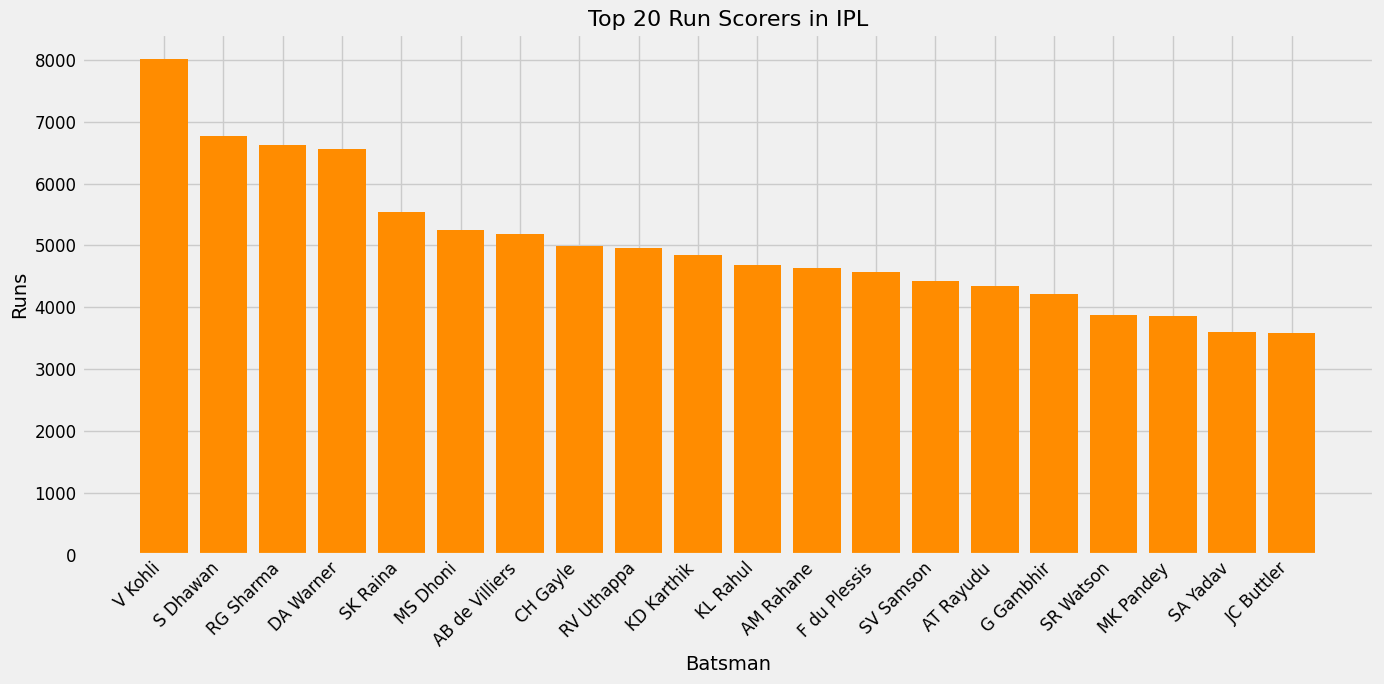

In [16]:

# 3.2 Player Performance Analysis
print("\n--- Player Performance Analysis ---")

# Calculate runs scored by each batsman
batsman_runs = deliveries.groupby('batter')['batsman_runs'].sum().sort_values(ascending=False)
top_run_scorers = batsman_runs.head(20)

print("\nTop 20 Run Scorers:")
top_run_scorers.to_frame(name='Runs').style.background_gradient(cmap='viridis')

# Plot top 20 run scorers
plt.figure(figsize=(14, 7))
plt.bar(top_run_scorers.index, top_run_scorers.values, color='darkorange')
plt.title('Top 20 Run Scorers in IPL', fontsize=16)
plt.xlabel('Batsman', fontsize=14)
plt.ylabel('Runs', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top_run_scorers.png')
plt.show()


Batting Average and Strike Rate for Top 20 Run Scorers:


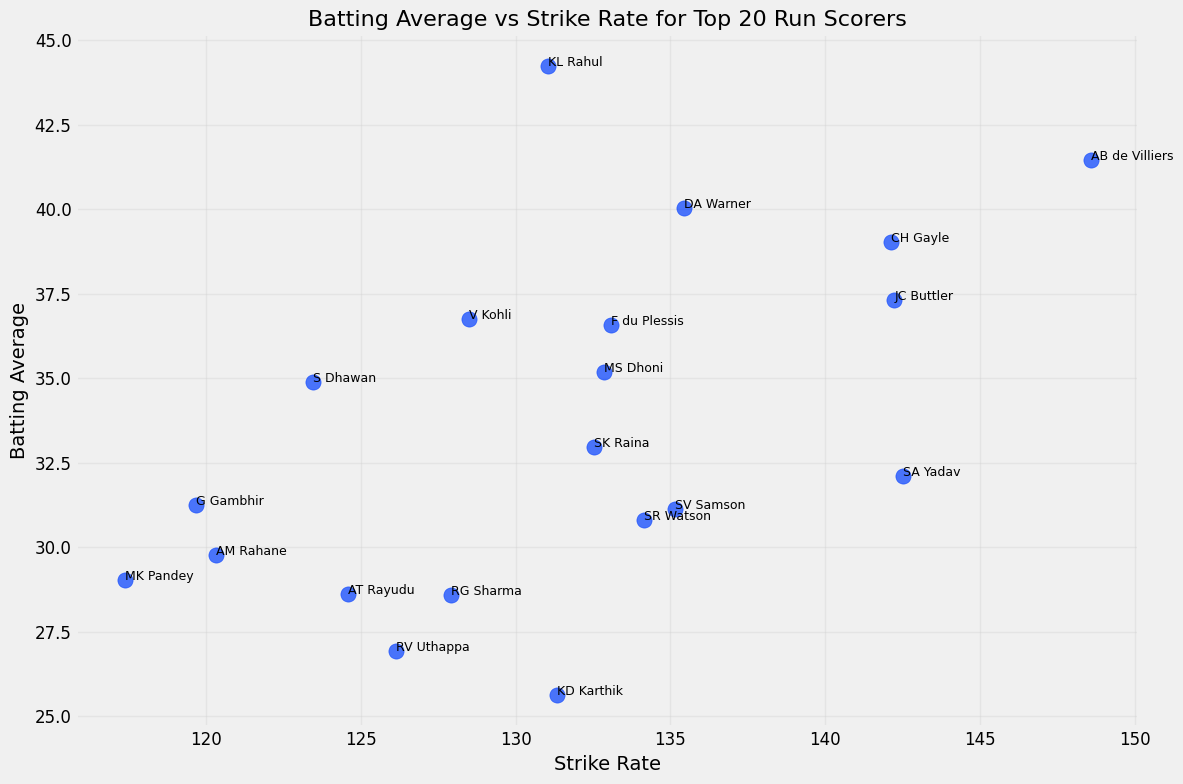

In [17]:

# Calculate batting average and strike rate for top run scorers
batsman_dismissals = deliveries[deliveries['is_wicket'] == 1].groupby('batter').size()
batsman_balls_faced = deliveries.groupby('batter').size()

batsman_stats = pd.DataFrame({
    'Runs': batsman_runs,
    'Dismissals': batsman_dismissals,
    'Balls_Faced': batsman_balls_faced
})

batsman_stats['Batting_Average'] = (batsman_stats['Runs'] / batsman_stats['Dismissals']).fillna(batsman_stats['Runs']).round(2)
batsman_stats['Strike_Rate'] = (batsman_stats['Runs'] / batsman_stats['Balls_Faced'] * 100).round(2)

# Filter for top 20 run scorers
top_batsman_stats = batsman_stats.loc[top_run_scorers.index]

print("\nBatting Average and Strike Rate for Top 20 Run Scorers:")
# print(top_batsman_stats[['Batting_Average', 'Strike_Rate']])
top_batsman_stats[['Batting_Average', 'Strike_Rate']] \
    .style \
    .format({'Batting_Average': '{:.2f}', 'Strike_Rate': '{:.2f}'}) \
    .background_gradient(cmap='cividis')
# Plot batting average vs strike rate for top 20 run scorers
plt.figure(figsize=(12, 8))
plt.scatter(top_batsman_stats['Strike_Rate'], top_batsman_stats['Batting_Average'], s=120, alpha=0.7)

for i, batsman in enumerate(top_batsman_stats.index):
    plt.annotate(batsman, 
                 (top_batsman_stats['Strike_Rate'].iloc[i], top_batsman_stats['Batting_Average'].iloc[i]),
                 fontsize=9)

plt.title('Batting Average vs Strike Rate for Top 20 Run Scorers', fontsize=16)
plt.xlabel('Strike Rate', fontsize=14)
plt.ylabel('Batting Average', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('batting_avg_vs_strike_rate.png')
plt.show()



Player with Highest Average (>50 matches): KL Rahul - 44.24
Player with Highest Strike Rate (>50 matches): AD Russell - 164.22

Top 20 Wicket Takers:


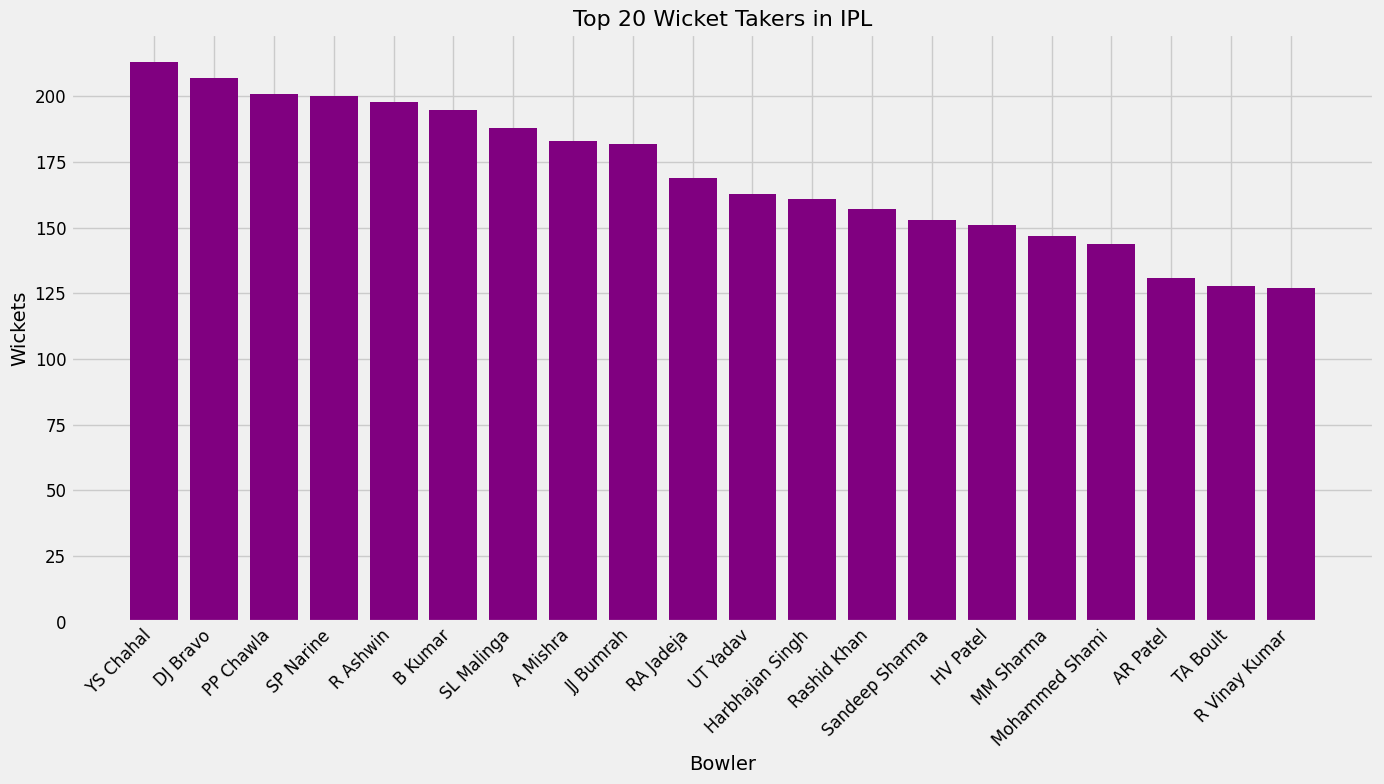

In [18]:

# Find highest average and strike rate for players with >50 matches
# First, count matches played by each player
player_matches = {}
for player in batsman_stats.index:
    match_ids = deliveries[deliveries['batter'] == player]['match_id'].unique()
    player_matches[player] = len(match_ids)

batsman_stats['Matches_Played'] = pd.Series(player_matches)

# Filter for players with >50 matches
qualified_players = batsman_stats[batsman_stats['Matches_Played'] > 50]
highest_avg_player = qualified_players.loc[qualified_players['Batting_Average'].idxmax()]
highest_sr_player = qualified_players.loc[qualified_players['Strike_Rate'].idxmax()]

print(f"\nPlayer with Highest Average (>50 matches): {highest_avg_player.name} - {highest_avg_player['Batting_Average']}")
print(f"Player with Highest Strike Rate (>50 matches): {highest_sr_player.name} - {highest_sr_player['Strike_Rate']}")


# Calculate wickets taken by each bowler
bowler_wickets = deliveries[deliveries['is_wicket'] == 1].groupby('bowler').size().sort_values(ascending=False)
top_wicket_takers = bowler_wickets.head(20)

print("\nTop 20 Wicket Takers:")
top_wicket_takers.to_frame(name='Wickets').style.background_gradient(cmap='viridis')
# Plot top wicket takers
plt.figure(figsize=(14, 8))
plt.bar(top_wicket_takers.index, top_wicket_takers.values, color='purple')
plt.title('Top 20 Wicket Takers in IPL', fontsize=16)
plt.xlabel('Bowler', fontsize=14)
plt.ylabel('Wickets', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top_wicket_takers.png')
plt.show()




Top 20 Highest Individual Scores:


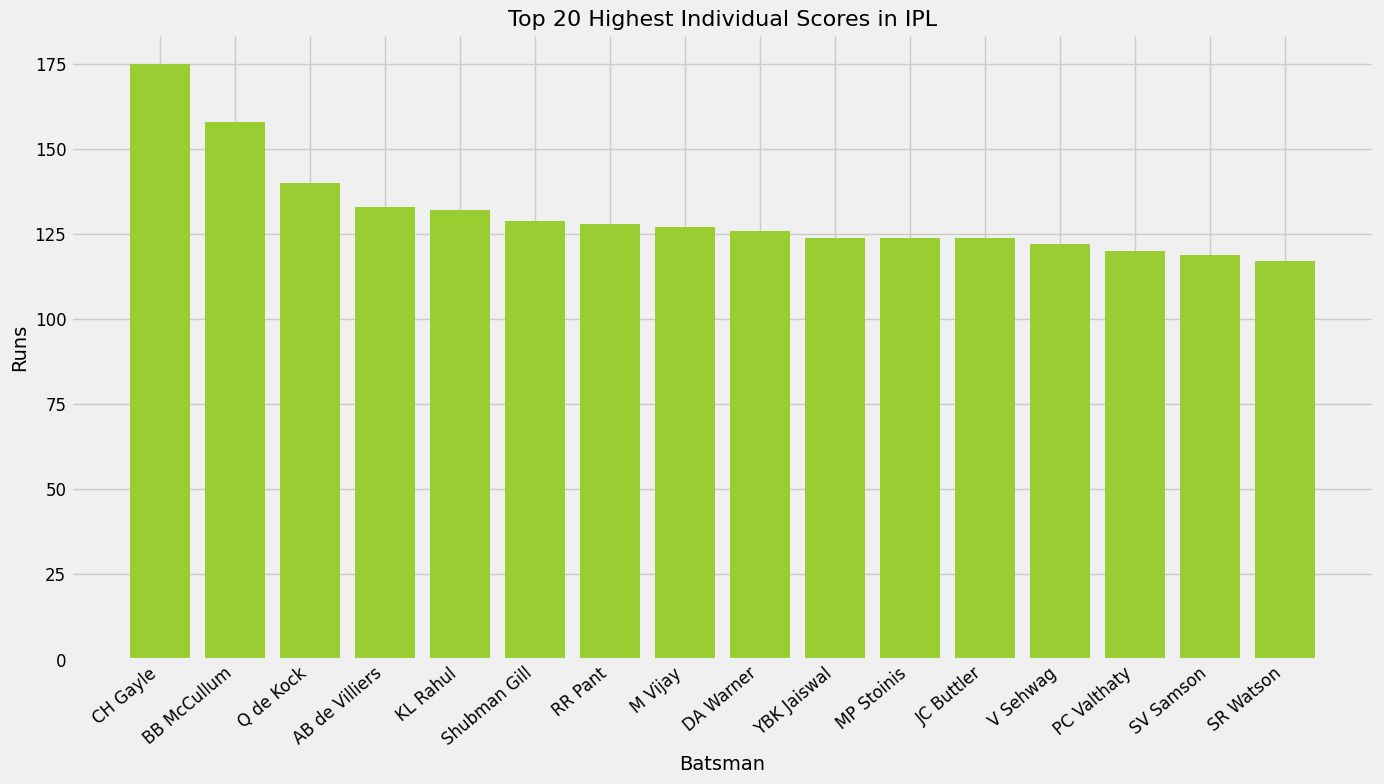

In [19]:

# Find highest individual scores
batsman_match_runs = deliveries.groupby(['match_id', 'batter'])['batsman_runs'].sum().reset_index()
print("\nTop 20 Highest Individual Scores:")
# Select only the desired columns
highest_scores = batsman_match_runs.sort_values('batsman_runs', ascending=False).head(20)[['batter', 'batsman_runs']]
highest_scores.style.background_gradient(cmap='viridis')
# Plot highest individual scores
plt.figure(figsize=(14, 8))
plt.bar(highest_scores['batter'], highest_scores['batsman_runs'], color='yellowgreen')
plt.title('Top 20 Highest Individual Scores in IPL', fontsize=16)
plt.xlabel('Batsman', fontsize=14)
plt.ylabel('Runs', fontsize=14)
plt.xticks(rotation=40, ha='right')
plt.tight_layout()
plt.savefig('highest_individual_scores.png')
plt.show()

In [21]:
# Man of the Match analysis
mom_counts = matches['player_of_match'].value_counts().head(20)

print("\nTop 20 Players with Most Man of the Match Awards:")
print(mom_counts)



Top 20 Players with Most Man of the Match Awards:
player_of_match
AB de Villiers    25
CH Gayle          22
RG Sharma         19
DA Warner         18
V Kohli           18
MS Dhoni          17
RA Jadeja         16
YK Pathan         16
SR Watson         16
AD Russell        15
SP Narine         15
KA Pollard        14
SK Raina          14
G Gambhir         13
KL Rahul          13
AM Rahane         13
JC Buttler        13
A Mishra          12
Rashid Khan       12
S Dhawan          12
Name: count, dtype: int64


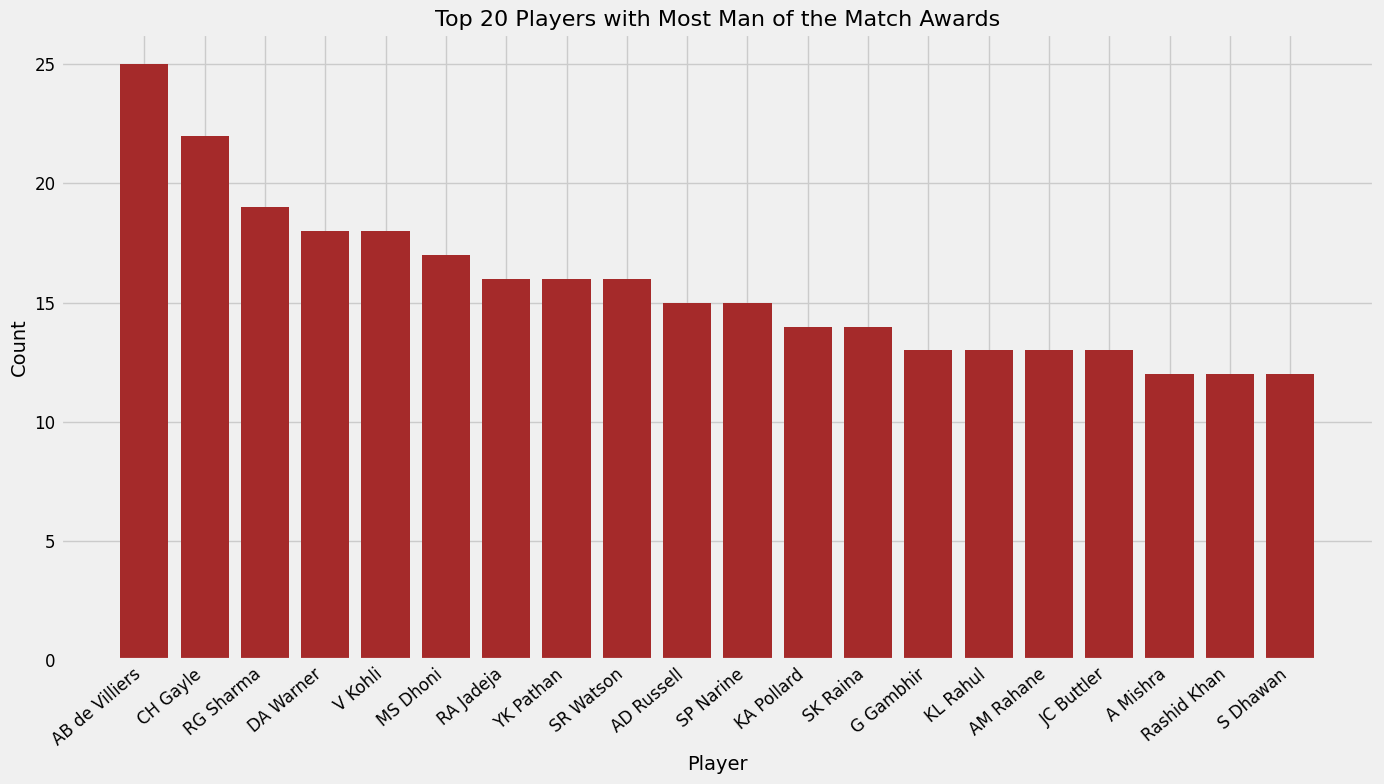

In [23]:

# Plot Man of the Match counts
plt.figure(figsize=(14, 8))
plt.bar(mom_counts.index, mom_counts.values, color='brown')
plt.title('Top 20 Players with Most Man of the Match Awards', fontsize=16)
plt.xlabel('Player', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=40, ha='right')
plt.tight_layout()
plt.savefig('mom_counts.png')
plt.show()

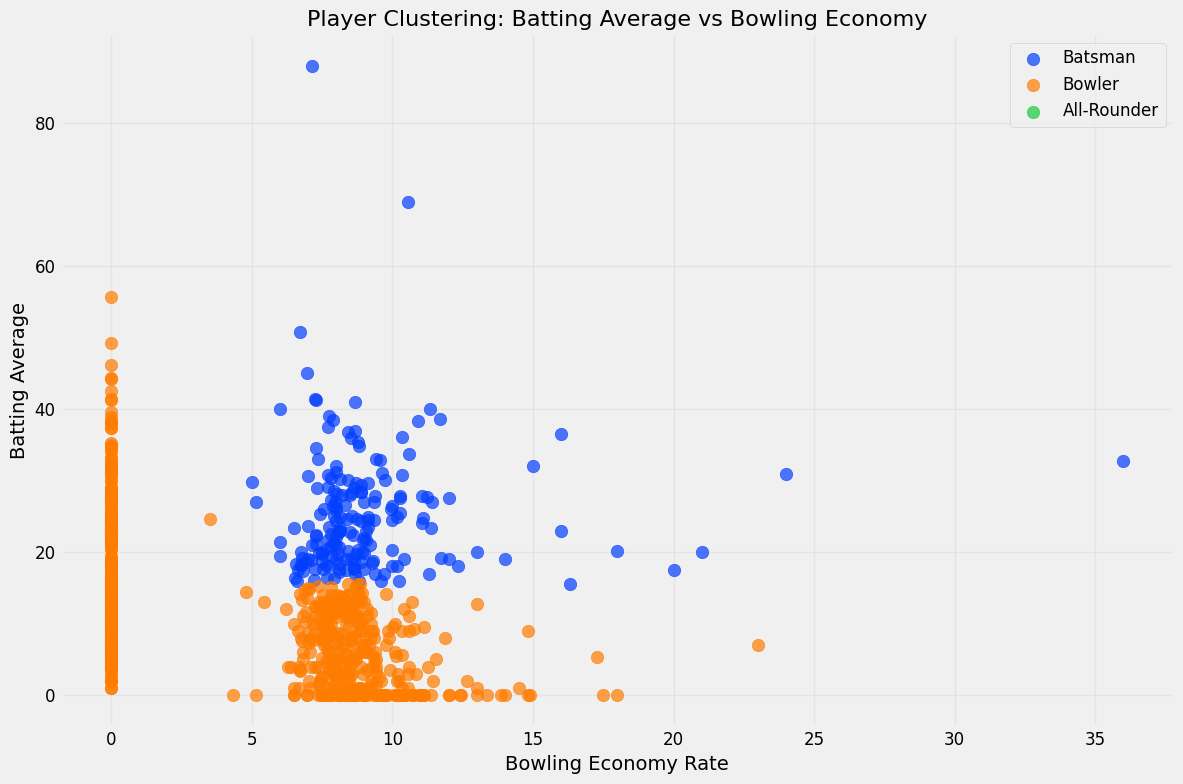

In [24]:
# Player Role Analysis using Clustering

# Calculate batting average
batsman_dismissals = deliveries[deliveries['is_wicket'] == 1].groupby('batter').size()
batsman_balls_faced = deliveries.groupby('batter').size()

batsman_stats = pd.DataFrame({
    'Runs': batsman_runs,
    'Dismissals': batsman_dismissals,
    'Balls_Faced': batsman_balls_faced
})

batsman_stats['Batting_Average'] = (batsman_stats['Runs'] / batsman_stats['Dismissals']).fillna(batsman_stats['Runs']).round(2)

# Calculate bowling economy
bowler_runs = deliveries.groupby('bowler')['total_runs'].sum()
bowler_balls = deliveries.groupby('bowler').size()
bowler_economy = (bowler_runs / (bowler_balls / 6)).round(2)

# Combine batting and bowling stats
player_roles = pd.DataFrame({
    'Batting_Average': batsman_stats['Batting_Average'],
    'Bowling_Economy': bowler_economy
}).fillna(0)  # Fill NaN values with 0 for players who are either batsmen or bowlers only

# Filter for players with sufficient data
qualified_players = player_roles[(player_roles['Batting_Average'] > 0) | (player_roles['Bowling_Economy'] > 0)]
qualified_players = qualified_players.dropna()

# Perform K-Means clustering to identify player roles
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Standardize the data for better clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(qualified_players)

# Initialize K-Means with 3 clusters (Batsman, Bowler, All-Rounder)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
qualified_players['Cluster'] = kmeans.fit_predict(scaled_data)

# Interpret clusters
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_),
                               columns=['Batting_Average', 'Bowling_Economy'])

# Assign role labels based on cluster characteristics
role_mapping = {}
for i in range(3):
    avg = cluster_centers.iloc[i]['Batting_Average']
    eco = cluster_centers.iloc[i]['Bowling_Economy']
    
    if avg > 25 and eco < 7:
        role_mapping[i] = 'All-Rounder'
    elif avg > 25:
        role_mapping[i] = 'Batsman'
    else:
        role_mapping[i] = 'Bowler'

qualified_players['Role'] = qualified_players['Cluster'].map(role_mapping)

# Plot the clusters
plt.figure(figsize=(12, 8))
for role in ['Batsman', 'Bowler', 'All-Rounder']:
    subset = qualified_players[qualified_players['Role'] == role]
    plt.scatter(subset['Bowling_Economy'], subset['Batting_Average'],
                label=role, s=80, alpha=0.7)

plt.title('Player Clustering: Batting Average vs Bowling Economy', fontsize=16)
plt.xlabel('Bowling Economy Rate', fontsize=14)
plt.ylabel('Batting Average', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('player_clustering.png')
plt.show()


In [25]:

# Display the results
print("\nPlayer Role Analysis:")
print(qualified_players['Role'].value_counts())
print("\nSample of players and their assigned roles:")
print(qualified_players.sample(10))



Player Role Analysis:
Role
Bowler     547
Batsman    183
Name: count, dtype: int64

Sample of players and their assigned roles:
                 Batting_Average  Bowling_Economy  Cluster     Role
VRV Singh                   4.00             8.88        0   Bowler
AD Hales                   24.67             0.00        1   Bowler
KS Williamson              36.14            10.33        2  Batsman
DJM Short                  16.43             7.67        2  Batsman
AK Markram                 30.15             8.44        2  Batsman
BB McCullum                27.19             0.00        1   Bowler
JH Kallis                  27.27             7.83        2  Batsman
Sohail Tanvir              12.00             6.23        0   Bowler
MV Boucher                 26.27             0.00        1   Bowler
Abhishek Sharma            25.04             8.55        2  Batsman


In [27]:
# Identify top batsmen in each run category
# Calculate 6s, 4s, 2s, and 1s for each batsman
batsman_6s = deliveries[deliveries['batsman_runs'] == 6].groupby('batter').size()
batsman_4s = deliveries[deliveries['batsman_runs'] == 4].groupby('batter').size()
batsman_2s = deliveries[deliveries['batsman_runs'] == 2].groupby('batter').size()
batsman_1s = deliveries[deliveries['batsman_runs'] == 1].groupby('batter').size()

# Get top 10 in each category
top_6s = batsman_6s.sort_values(ascending=False).head(10)
top_4s = batsman_4s.sort_values(ascending=False).head(10)
top_2s = batsman_2s.sort_values(ascending=False).head(10)
top_1s = batsman_1s.sort_values(ascending=False).head(10)


In [28]:

print("\nTop 10 Batsmen by 6s:")
print(top_6s)



Top 10 Batsmen by 6s:
batter
CH Gayle          359
RG Sharma         281
V Kohli           273
AB de Villiers    253
MS Dhoni          252
DA Warner         236
KA Pollard        224
AD Russell        209
SV Samson         206
SK Raina          204
dtype: int64


In [29]:
print("\nTop 10 Batsmen by 4s:")
print(top_4s)



Top 10 Batsmen by 4s:
batter
S Dhawan        768
V Kohli         708
DA Warner       663
RG Sharma       599
SK Raina        506
G Gambhir       492
RV Uthappa      481
AM Rahane       479
KD Karthik      466
F du Plessis    422
dtype: int64


In [30]:
print("\nTop 10 Batsmen by 2s:")
print(top_2s)



Top 10 Batsmen by 2s:
batter
V Kohli           445
DA Warner         370
MS Dhoni          340
S Dhawan          299
SK Raina          271
AB de Villiers    268
RG Sharma         263
KD Karthik        258
AM Rahane         257
G Gambhir         249
dtype: int64


In [31]:
print("\nTop 10 Batsmen by 1s:")
print(top_1s)


Top 10 Batsmen by 1s:
batter
V Kohli       2591
S Dhawan      2102
RG Sharma     1996
SK Raina      1708
DA Warner     1682
MS Dhoni      1554
AM Rahane     1537
AT Rayudu     1495
KL Rahul      1464
KD Karthik    1464
dtype: int64


In [36]:

## Seasonal Analysis
print("\n--- Seasonal Analysis ---")

# # Extract year from date for seasonal analysis
# matches['season'] = pd.to_datetime(matches['date']).dt.year

# # Calculate average runs per match per season
# season_runs = matches.groupby('season')['total_runs'].sum()
# season_matches = matches.groupby('season').size()
# avg_runs_per_season = (season_runs / season_matches).round(2)

# avg_runs_df = pd.DataFrame({'Season': avg_runs_per_season.index, 'Avg_Runs_Per_Match': avg_runs_per_season.values})
# print("\nAverage Runs Per Match Per Season:")
# print(avg_runs_df)

# # Plot average runs per match per season
# plt.figure(figsize=(14, 8))
# plt.plot(avg_runs_df['Season'], avg_runs_df['Avg_Runs_Per_Match'], marker='o', linewidth=2)
# plt.title('Average Runs Per Match Per Season', fontsize=16)
# plt.xlabel('Season', fontsize=14)
# plt.ylabel('Average Runs', fontsize=14)
# plt.grid(True, alpha=0.3)
# plt.xticks(avg_runs_df['Season'], rotation=45)
# plt.tight_layout()
# plt.savefig('avg_runs_per_season.png')
# plt.show()
# Calculate total runs for each match
match_runs = deliveries.groupby('match_id')['total_runs'].sum().reset_index()

# Merge match_runs with matches DataFrame
matches_with_runs = pd.merge(matches, match_runs, left_on='id', right_on='match_id')

# Extract year from date for seasonal analysis
matches_with_runs['season'] = pd.to_datetime(matches_with_runs['date']).dt.year

# Calculate average runs per match per season
season_runs = matches_with_runs.groupby('season')['total_runs'].sum()
season_matches = matches_with_runs.groupby('season').size()
avg_runs_per_season = (season_runs / season_matches).round(2)

avg_runs_df = pd.DataFrame({'Season': avg_runs_per_season.index, 'Avg_Runs_Per_Match': avg_runs_per_season.values})
print("\nAverage Runs Per Match Per Season:")
avg_runs_df.style.background_gradient(cmap='BuGn')


--- Seasonal Analysis ---

Average Runs Per Match Per Season:


,Season,Avg_Runs_Per_Match
0,2008,309.260000
1,2009,286.890000
2,2010,314.720000
3,2011,289.780000
4,2012,303.420000
5,2013,297.390000
6,2014,315.520000
7,2015,311.070000
8,2016,314.370000
9,2017,318.410000


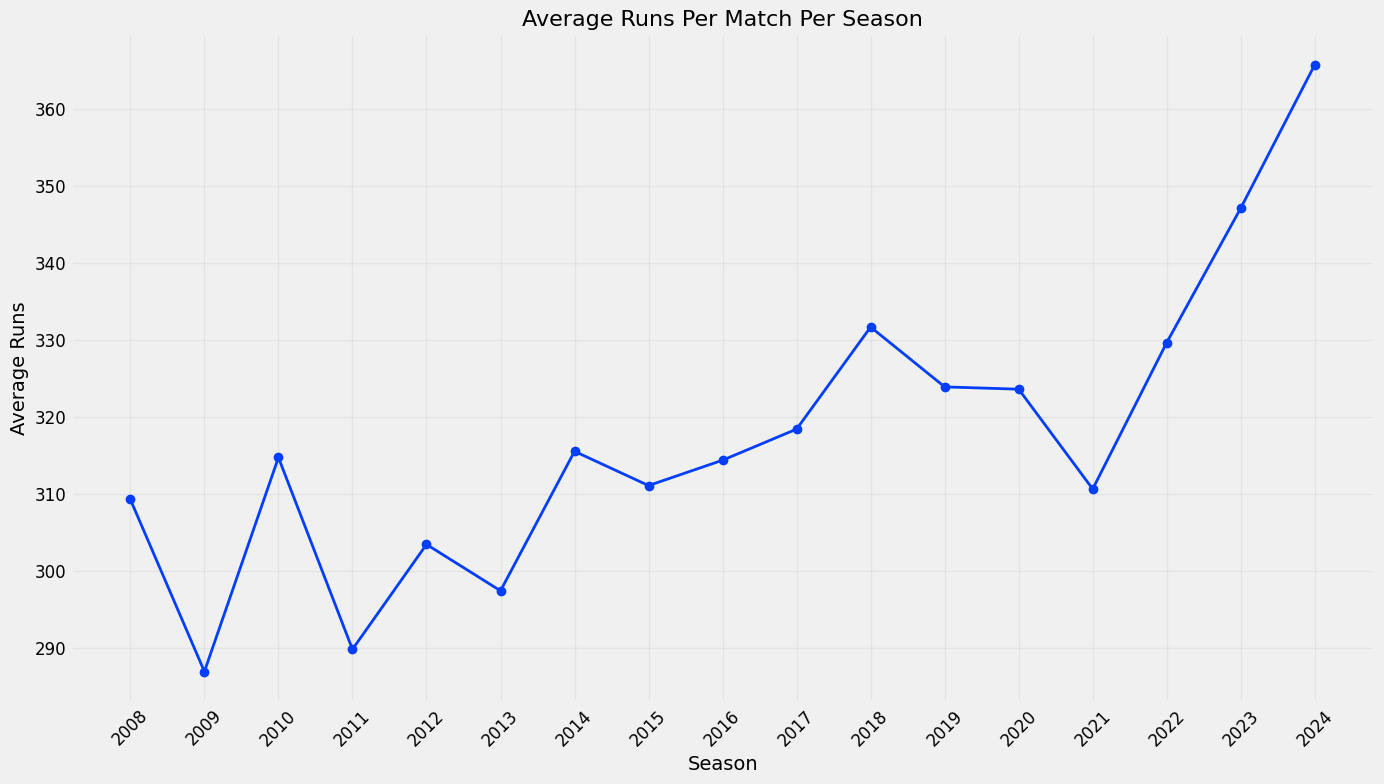

In [37]:

# Plot average runs per match per season
plt.figure(figsize=(14, 8))
plt.plot(avg_runs_df['Season'], avg_runs_df['Avg_Runs_Per_Match'], marker='o', linewidth=2)
plt.title('Average Runs Per Match Per Season', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Average Runs', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(avg_runs_df['Season'], rotation=45)
plt.tight_layout()
plt.savefig('avg_runs_per_season.png')
plt.show()

In [42]:
# Identify targets of 200+ runs per season
# First, calculate total runs per match per team
match_team_runs = deliveries.groupby(['match_id', 'batting_team'])['total_runs'].sum().reset_index()

# Filter for scores of 200 or more
high_scores_matches = match_team_runs[match_team_runs['total_runs'] >= 200]

# Merge with matches to get the season information
high_scores_with_season = pd.merge(high_scores_matches, 
                                   matches[['id', 'season']], 
                                   left_on='match_id', 
                                   right_on='id')

# Count high scores per season
high_scores = high_scores_with_season.groupby('season').size()
high_scores_df = pd.DataFrame({'Season': high_scores.index, '200+_Scores': high_scores.values})

print("\nNumber of 200+ Scores Per Season:")
print(high_scores_df)



Number of 200+ Scores Per Season:
    Season  200+_Scores
0     2008           11
1     2009            1
2     2010            9
3     2011            5
4     2012            5
5     2013            4
6     2014            9
7     2015            8
8     2016            6
9     2017           10
10    2018           15
11    2019           11
12    2020           13
13    2021            9
14    2022           18
15    2023           37
16    2024           41


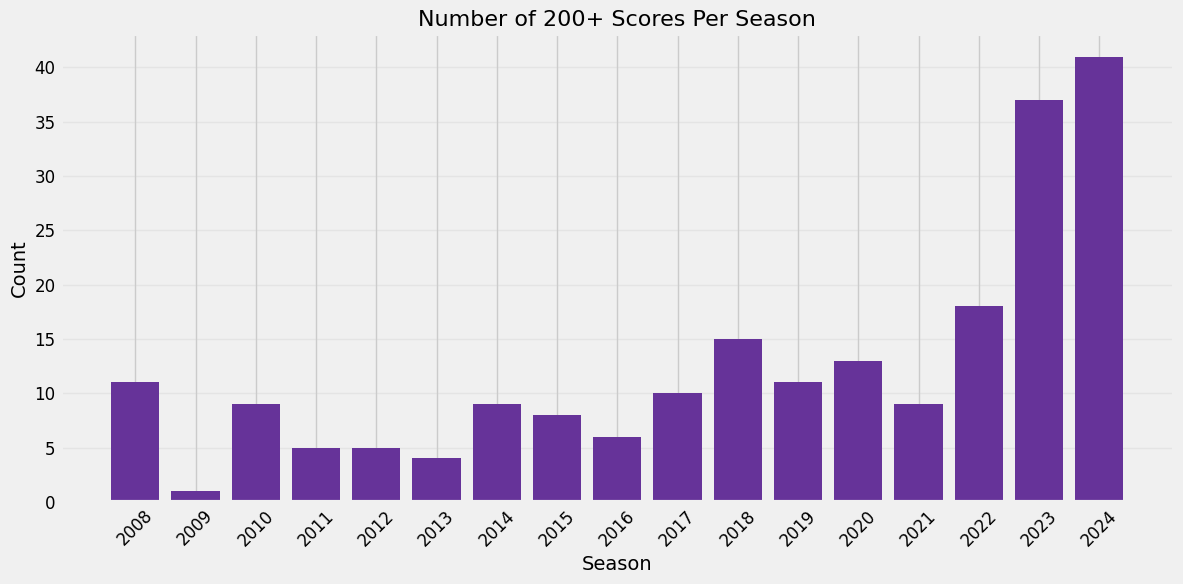

In [46]:

# Plot 200+ scores per season
plt.figure(figsize=(12, 6))
plt.bar(high_scores_df['Season'], high_scores_df['200+_Scores'], color='rebeccapurple')
plt.title('Number of 200+ Scores Per Season', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(high_scores_df['Season'], rotation=45)
plt.tight_layout()
plt.savefig('high_scores_per_season.png')
plt.show()

In [70]:
# Find average score of each team per season
# First, calculate total runs per match per team
match_team_runs = deliveries.groupby(['match_id', 'batting_team'])['total_runs'].sum().reset_index()

# Get season information from matches DataFrame
match_seasons = matches[['id', 'season']].copy()
match_seasons.rename(columns={'id': 'match_id'}, inplace=True)

# Merge to get season information for each match-team combination
team_season_runs = pd.merge(match_team_runs, match_seasons, on='match_id')

# Group by season and team to calculate average score
team_season_avg = team_season_runs.groupby(['season', 'batting_team'])['total_runs'].mean().reset_index()
team_season_avg.columns = ['season', 'Team', 'Avg_Score']

# Sort values for better readability
team_season_df = team_season_avg.sort_values(['season', 'Team'])

print("\nAverage Score of Each Team Per Season (Sample):")
team_season_df.tail(20).style.background_gradient(cmap='cividis')



Average Score of Each Team Per Season (Sample):


,season,Team,Avg_Score
126,2023,Chennai Super Kings,180.800000
127,2023,Delhi Capitals,155.857143
128,2023,Gujarat Titans,179.647059
129,2023,Kolkata Knight Riders,175.928571
130,2023,Lucknow Super Giants,165.266667
131,2023,Mumbai Indians,184.062500
132,2023,Punjab Kings,182.571429
133,2023,Rajasthan Royals,172.785714
134,2023,Royal Challengers Bangalore,178.714286
135,2023,Sunrisers Hyderabad,169.714286


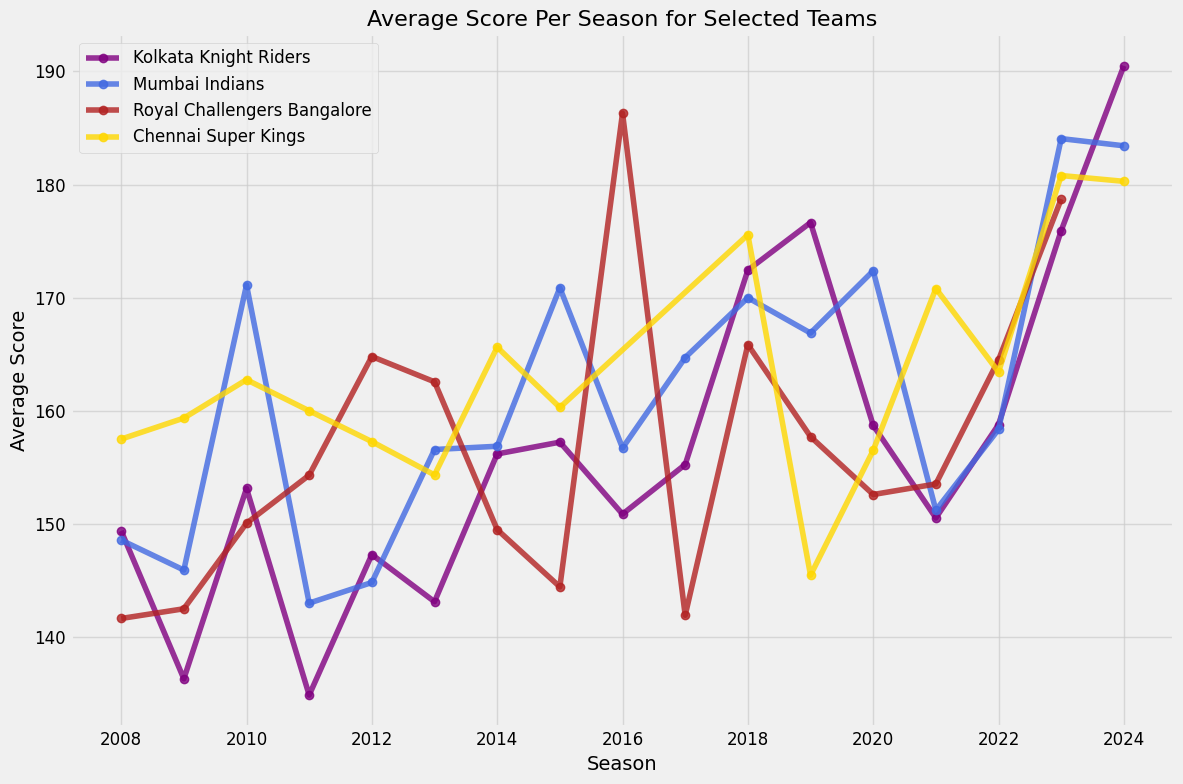

In [72]:
team_colors = {
    'Kolkata Knight Riders': 'purple',
    'Mumbai Indians': 'royalblue',
    'Royal Challengers Bangalore': 'firebrick',
    'Chennai Super Kings': 'gold'
}

# Plot average score for a few selected teams across seasons
selected_teams = ['Kolkata Knight Riders', 'Mumbai Indians', 'Royal Challengers Bangalore', 'Chennai Super Kings']
plt.figure(figsize=(12, 8))

for team in selected_teams:
    team_data = team_season_df[team_season_df['Team'] == team]
    if not team_data.empty:
        plt.plot(
            team_data['season'],
            team_data['Avg_Score'],
            marker='o',
            linewidth=4,
            label=team,
            color=team_colors[team],
            alpha=0.8
        )

plt.title('Average Score Per Season for Selected Teams', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Average Score', fontsize=14)
plt.grid(True, alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('team_avg_score_per_season.png')
plt.show()


In [76]:
# Create DataFrame for Orange Cap holders
orange_cap_data = {
    'Season': [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Player': ['Shaun Marsh', 'Matthew Hayden', 'Sachin Tendulkar', 'Chris Gayle', 'Chris Gayle', 'Michael Hussey', 
               'Robin Uthappa', 'David Warner', 'Virat Kohli', 'David Warner', 'Kane Williamson', 'David Warner', 
               'KL Rahul', 'Ruturaj Gaikwad', 'Jos Buttler', 'Shubman Gill', 'Virat Kohli'],
    'Team': ['KXIP', 'CSK', 'MI', 'RCB', 'RCB', 'CSK', 'KKR', 'SRH', 'RCB', 'SRH', 'SRH', 'SRH', 
             'KXIP', 'CSK', 'RR', 'GT', 'RCB'],
    'Runs': [616, 572, 618, 608, 733, 733, 660, 562, 973, 641, 735, 692, 670, 635, 863, 890, 741],
    'Average': [68.0, 51.0, 47.0, 67.0, 61.0, 52.0, 44.0, 43.0, 81.0, 58.27, 52.5, 69.2, 55.83, 45.35, 57.53, 59.33, 49.4],
    'Strike_Rate': [139.0, 144.0, 132.0, 183.0, 160.0, 129.0, 137.0, 156.0, 152.0, 141.81, 142.44, 143.87, 129.34, 136.26, 149.05, 157.8, 155.0]
}

orange_cap_df = pd.DataFrame(orange_cap_data)


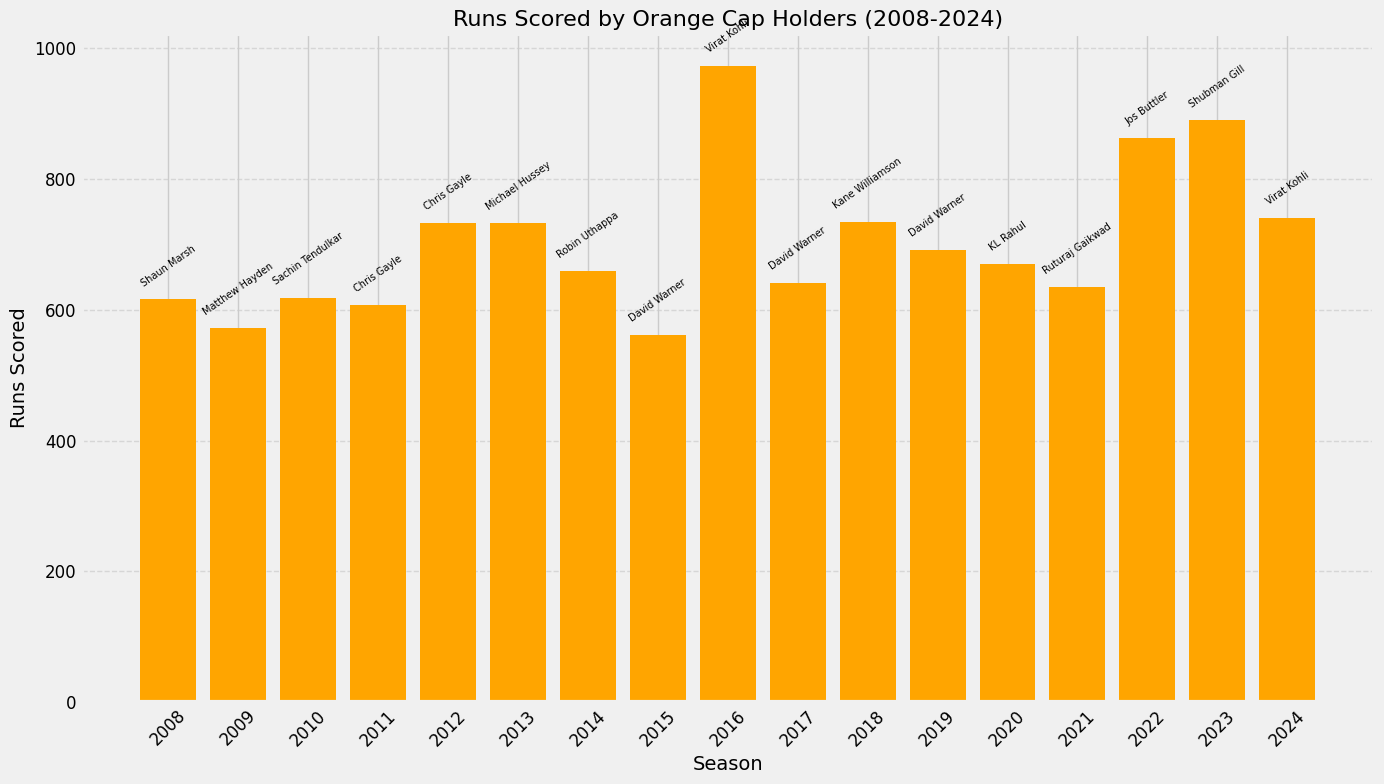

In [84]:

# Plot runs scored by Orange Cap holders across seasons
plt.figure(figsize=(14, 8))
bars = plt.bar(orange_cap_df['Season'], orange_cap_df['Runs'], color='orange')
plt.xlabel('Season', fontsize=14)
plt.ylabel('Runs Scored', fontsize=14)
plt.title('Runs Scored by Orange Cap Holders (2008-2024)', fontsize=16)
plt.xticks(orange_cap_df['Season'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Add player names on top of bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
             orange_cap_df['Player'][i], ha='center', rotation=35, fontsize=7)

plt.tight_layout()
plt.savefig('orange_cap_runs.png')
plt.show()


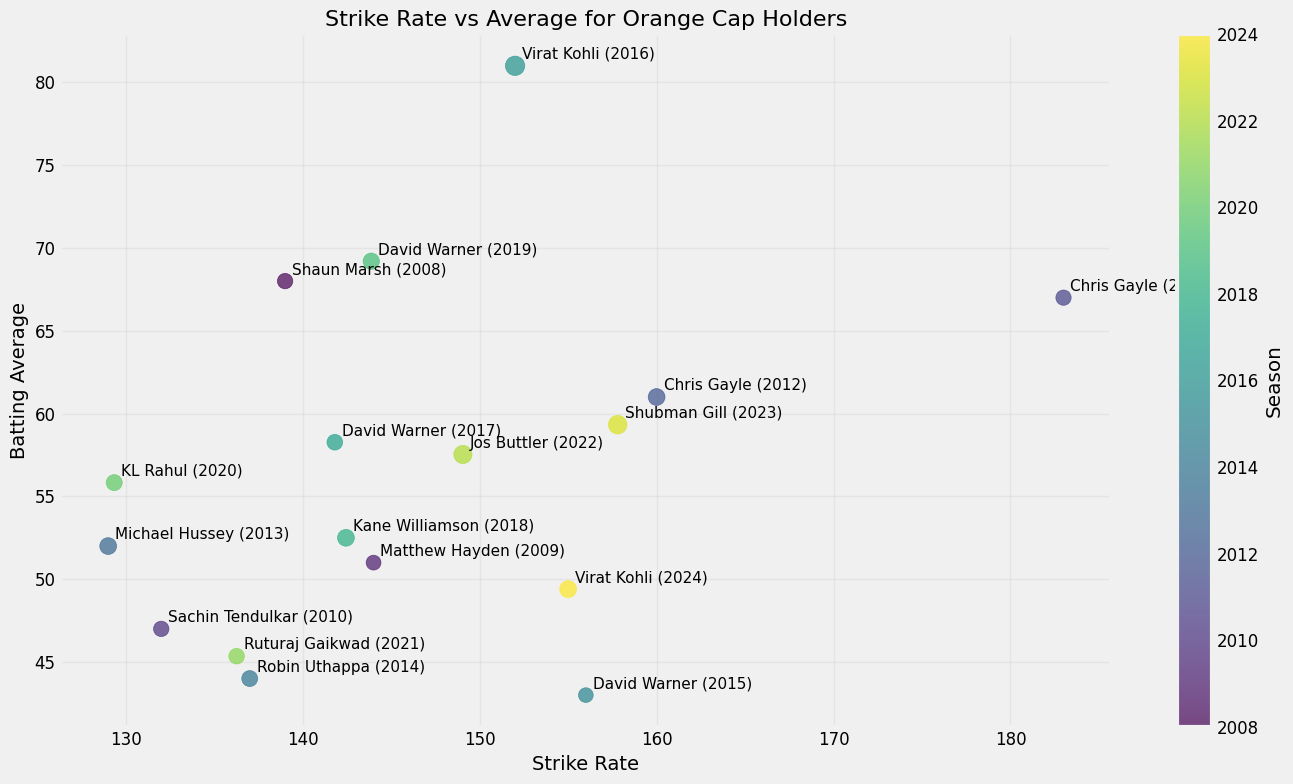

In [90]:

# Analyze strike rate vs average for Orange Cap holders
plt.figure(figsize=(14, 8))
scatter = plt.scatter(orange_cap_df['Strike_Rate'], orange_cap_df['Average'], 
                     s=orange_cap_df['Runs']/5, alpha=0.7, c=orange_cap_df['Season'], cmap='viridis')

# Add player names as annotations
for i, player in enumerate(orange_cap_df['Player']):
    plt.annotate(f"{player} ({orange_cap_df['Season'][i]})", 
                (orange_cap_df['Strike_Rate'][i], orange_cap_df['Average'][i]),
                xytext=(5, 5), textcoords='offset points', fontsize=11)

plt.xlabel('Strike Rate', fontsize=14)
plt.ylabel('Batting Average', fontsize=14)
plt.title('Strike Rate vs Average for Orange Cap Holders', fontsize=16)
plt.colorbar(scatter, label='Season')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('orange_cap_sr_vs_avg.png')
plt.show()


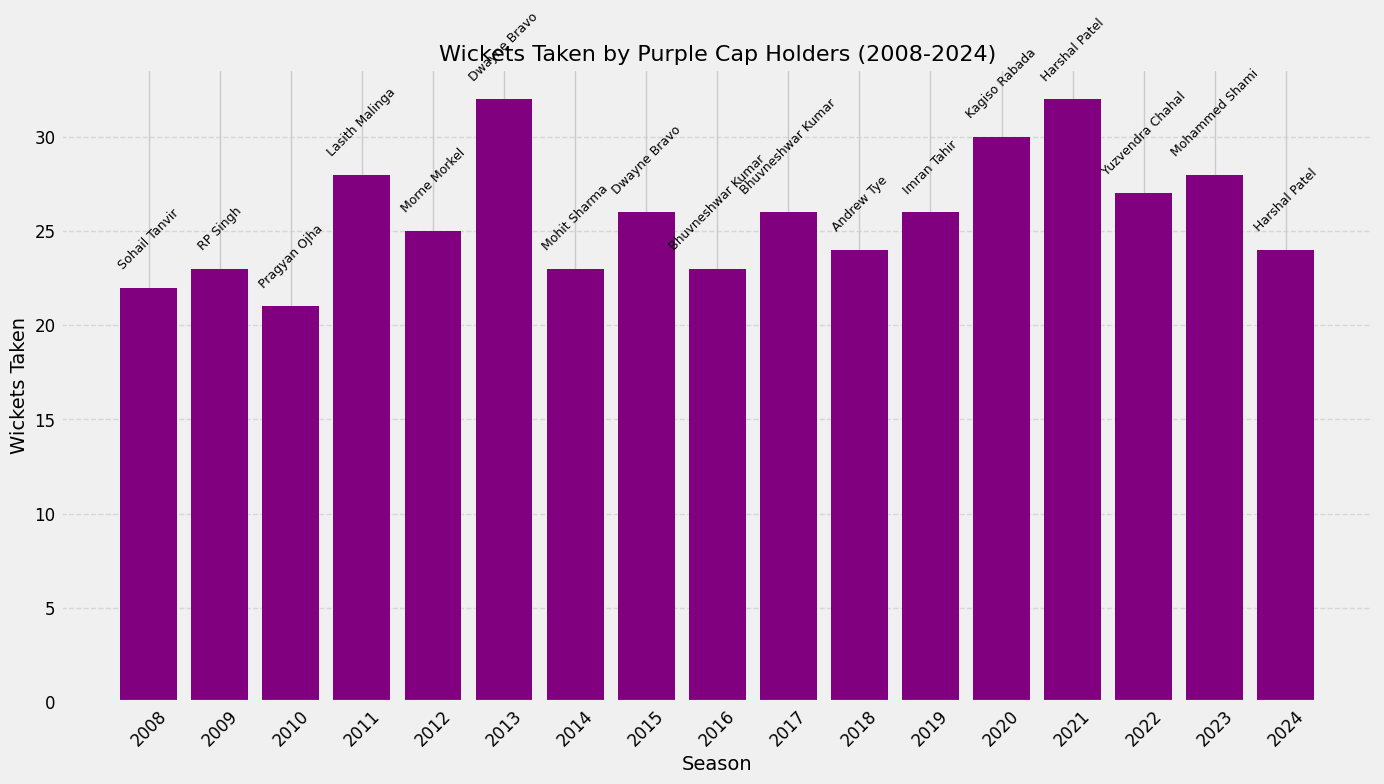

In [ ]:
# Create DataFrame for Purple Cap holders
purple_cap_data = {
    'Season': [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Player': ['Sohail Tanvir', 'RP Singh', 'Pragyan Ojha', 'Lasith Malinga', 'Morne Morkel', 'Dwayne Bravo', 
               'Mohit Sharma', 'Dwayne Bravo', 'Bhuvneshwar Kumar', 'Bhuvneshwar Kumar', 'Andrew Tye', 
               'Imran Tahir', 'Kagiso Rabada', 'Harshal Patel', 'Yuzvendra Chahal', 'Mohammed Shami', 'Harshal Patel'],
    'Team': ['RR', 'DC', 'DC', 'MI', 'DD', 'CSK', 'CSK', 'CSK', 'SRH', 'SRH', 'KXIP', 'CSK', 'DC', 'RCB', 'RR', 'GT', 'PBKS'],
    'Wickets': [22, 23, 21, 28, 25, 32, 23, 26, 23, 26, 24, 26, 30, 32, 27, 28, 24],
    'Matches': [11, 16, 16, 16, 16, 18, 16, 17, 17, 14, 14, 17, 17, 15, 17, 17, 14],
    'Economy': [6.46, 6.98, 7.29, 5.95, 7.19, 7.95, 8.39, 8.14, 7.42, 7.05, 8.00, 6.69, 8.34, 8.14, 7.75, 8.03, 8.00],
    'Average': [12.09, 18.13, 20.42, 13.39, 18.12, 15.53, 19.65, 16.38, 21.30, 14.19, 18.66, 16.57, 18.26, 14.34, 19.51, 18.64, 15.00]
}

purple_cap_df = pd.DataFrame(purple_cap_data)

# Calculate wickets per match
purple_cap_df['Wickets_per_Match'] = (purple_cap_df['Wickets'] / purple_cap_df['Matches']).round(2)

# Plot wickets taken by Purple Cap holders across seasons
plt.figure(figsize=(14, 8))
bars = plt.bar(purple_cap_df['Season'], purple_cap_df['Wickets'], color='purple')
plt.xlabel('Season', fontsize=14)
plt.ylabel('Wickets Taken', fontsize=14)
plt.title('Wickets Taken by Purple Cap Holders (2008-2024)', fontsize=16)
plt.xticks(purple_cap_df['Season'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add player names on top of bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             purple_cap_df['Player'][i], ha='center', rotation=45, fontsize=9)

plt.tight_layout()
plt.savefig('purple_cap_wickets.png')
plt.show()

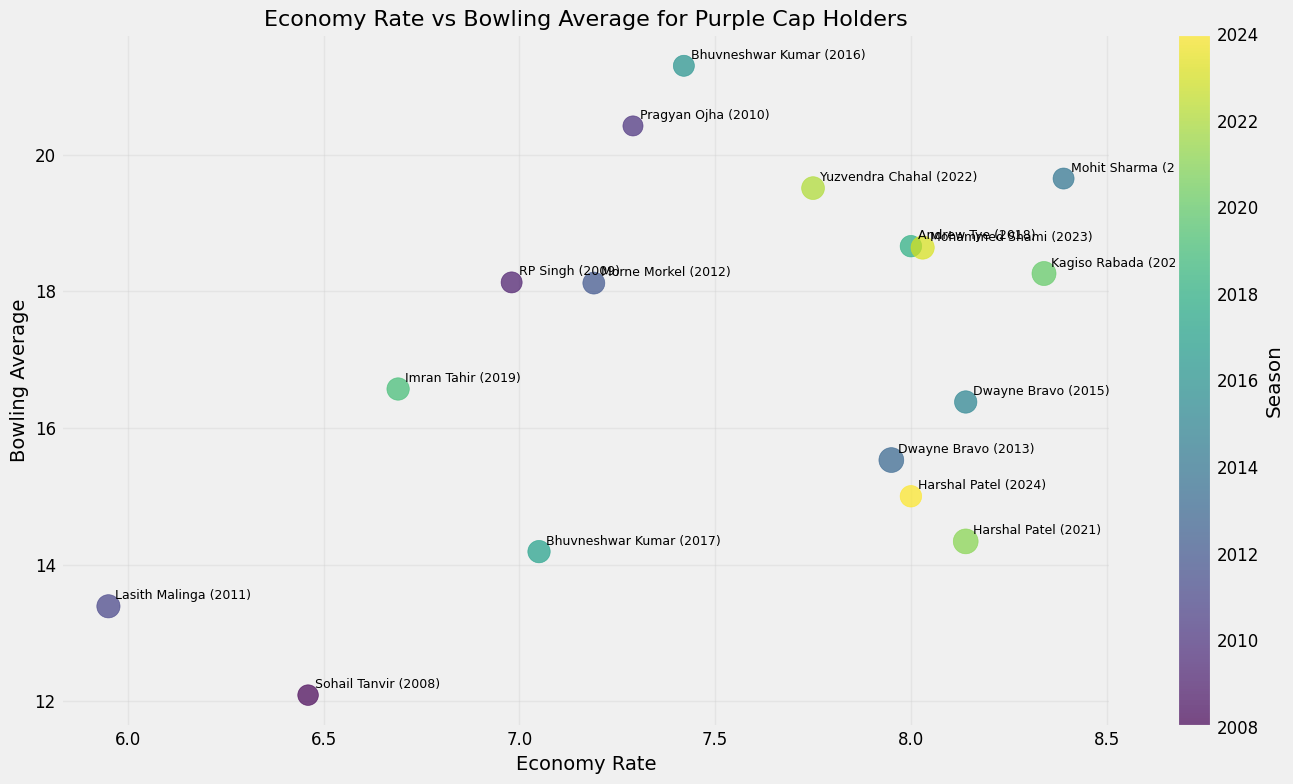

In [92]:

# Analyze economy rate vs average for Purple Cap holders
plt.figure(figsize=(14, 8))
scatter = plt.scatter(purple_cap_df['Economy'], purple_cap_df['Average'], 
                     s=purple_cap_df['Wickets']*10, alpha=0.7, c=purple_cap_df['Season'], cmap='viridis')

# Add player names as annotations
for i, player in enumerate(purple_cap_df['Player']):
    plt.annotate(f"{player} ({purple_cap_df['Season'][i]})", 
                (purple_cap_df['Economy'][i], purple_cap_df['Average'][i]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.xlabel('Economy Rate', fontsize=14)
plt.ylabel('Bowling Average', fontsize=14)
plt.title('Economy Rate vs Bowling Average for Purple Cap Holders', fontsize=16)
plt.colorbar(scatter, label='Season')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('purple_cap_economy_vs_avg.png')
plt.show()


In [ ]:
# Function to get top 10 bowlers for a given season
def get_top_bowlers_per_season(deliveries, matches, season):
    # Get match IDs for the specified season
    season_matches = matches[matches['season'] == season]['id'].tolist()
    
    # Filter deliveries for the season
    season_deliveries = deliveries[deliveries['match_id'].isin(season_matches)]
    
    # Count wickets for each bowler
    bowler_wickets = season_deliveries[season_deliveries['is_wicket'] == 1].groupby('bowler').size().reset_index(name='wickets')
    
    # Count balls bowled by each bowler
    bowler_balls = season_deliveries.groupby('bowler').size().reset_index(name='balls')
    
    # Calculate runs conceded by each bowler
    bowler_runs = season_deliveries.groupby('bowler')['total_runs'].sum().reset_index()
    
    # Merge all stats
    bowler_stats = pd.merge(bowler_wickets, bowler_balls, on='bowler')
    bowler_stats = pd.merge(bowler_stats, bowler_runs, on='bowler')
    
    # Calculate economy rate and average
    bowler_stats['economy'] = (bowler_stats['total_runs'] / (bowler_stats['balls'] / 6)).round(2)
    bowler_stats['average'] = (bowler_stats['total_runs'] / bowler_stats['wickets']).round(2)
    
    # Get top 10 bowlers by wickets
    top_bowlers = bowler_stats.sort_values('wickets', ascending=False).head(10)
    
    return top_bowlers

# Function to analyze top bowlers across all seasons
def analyze_top_bowlers_all_seasons(deliveries, matches):
    all_seasons = sorted(matches['season'].unique())
    all_top_bowlers = {}
    
    for season in all_seasons:
        top_bowlers = get_top_bowlers_per_season(deliveries, matches, season)
        all_top_bowlers[season] = top_bowlers
    
    return all_top_bowlers

# Function to plot top bowlers for a specific season
def plot_top_bowlers(top_bowlers, season):
    plt.figure(figsize=(14, 8))
    bars = plt.bar(top_bowlers['bowler'], top_bowlers['wickets'], color='purple')
    
    # Add economy rate as text on bars
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                 f"Econ: {top_bowlers['economy'].iloc[i]}", ha='center', fontsize=9)
    
    plt.xlabel('Bowler', fontsize=14)
    plt.ylabel('Wickets', fontsize=14)
    plt.title(f'Top 10 Bowlers in IPL {season}', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'top_bowlers_{season}.png')
    plt.show()


In [97]:
def orange_cap_analysis():
    # Create DataFrame for Orange Cap holders
    orange_cap_data = {
        'Season': [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
        'Player': ['Shaun Marsh', 'Matthew Hayden', 'Sachin Tendulkar', 'Chris Gayle', 'Chris Gayle', 'Michael Hussey', 
                   'Robin Uthappa', 'David Warner', 'Virat Kohli', 'David Warner', 'Kane Williamson', 'David Warner', 
                   'KL Rahul', 'Ruturaj Gaikwad', 'Jos Buttler', 'Shubman Gill', 'Virat Kohli'],
        'Team': ['KXIP', 'CSK', 'MI', 'RCB', 'RCB', 'CSK', 'KKR', 'SRH', 'RCB', 'SRH', 'SRH', 'SRH', 
                 'KXIP', 'CSK', 'RR', 'GT', 'RCB'],
        'Runs': [616, 572, 618, 608, 733, 733, 660, 562, 973, 641, 735, 692, 670, 635, 863, 890, 741],
        'Average': [68.0, 51.0, 47.0, 67.0, 61.0, 52.0, 44.0, 43.0, 81.0, 58.27, 52.5, 69.2, 55.83, 45.35, 57.53, 59.33, 49.4],
        'Strike_Rate': [139.0, 144.0, 132.0, 183.0, 160.0, 129.0, 137.0, 156.0, 152.0, 141.81, 142.44, 143.87, 129.34, 136.26, 149.05, 157.8, 155.0]
    }

    orange_cap_df = pd.DataFrame(orange_cap_data)

    # Plot runs scored by Orange Cap holders across seasons
    plt.figure(figsize=(14, 8))
    bars = plt.bar(orange_cap_df['Season'], orange_cap_df['Runs'], color='orange')
    plt.xlabel('Season', fontsize=14)
    plt.ylabel('Runs Scored', fontsize=14)
    plt.title('Runs Scored by Orange Cap Holders (2008-2024)', fontsize=16)
    plt.xticks(orange_cap_df['Season'], rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add player names on top of bars
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
                 orange_cap_df['Player'][i], ha='center', rotation=45, fontsize=9)

    plt.tight_layout()
    plt.savefig('orange_cap_runs.png')
    plt.show()

    # Analyze strike rate vs average for Orange Cap holders
    plt.figure(figsize=(14, 8))
    scatter = plt.scatter(orange_cap_df['Strike_Rate'], orange_cap_df['Average'], 
                         s=orange_cap_df['Runs']/5, alpha=0.7, c=orange_cap_df['Season'], cmap='viridis')

    # Add player names as annotations
    for i, player in enumerate(orange_cap_df['Player']):
        plt.annotate(f"{player} ({orange_cap_df['Season'][i]})", 
                    (orange_cap_df['Strike_Rate'][i], orange_cap_df['Average'][i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

    plt.xlabel('Strike Rate', fontsize=14)
    plt.ylabel('Batting Average', fontsize=14)
    plt.title('Strike Rate vs Average for Orange Cap Holders', fontsize=16)
    plt.colorbar(scatter, label='Season')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('orange_cap_sr_vs_avg.png')
    plt.show()


In [98]:
def purple_cap_analysis():
    # Create DataFrame for Purple Cap holders
    purple_cap_data = {
        'Season': [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
        'Player': ['Sohail Tanvir', 'RP Singh', 'Pragyan Ojha', 'Lasith Malinga', 'Morne Morkel', 'Dwayne Bravo', 
                   'Mohit Sharma', 'Dwayne Bravo', 'Bhuvneshwar Kumar', 'Bhuvneshwar Kumar', 'Andrew Tye', 
                   'Imran Tahir', 'Kagiso Rabada', 'Harshal Patel', 'Yuzvendra Chahal', 'Mohammed Shami', 'Harshal Patel'],
        'Team': ['RR', 'DC', 'DC', 'MI', 'DD', 'CSK', 'CSK', 'CSK', 'SRH', 'SRH', 'KXIP', 'CSK', 'DC', 'RCB', 'RR', 'GT', 'PBKS'],
        'Wickets': [22, 23, 21, 28, 25, 32, 23, 26, 23, 26, 24, 26, 30, 32, 27, 28, 24],
        'Matches': [11, 16, 16, 16, 16, 18, 16, 17, 17, 14, 14, 17, 17, 15, 17, 17, 14],
        'Economy': [6.46, 6.98, 7.29, 5.95, 7.19, 7.95, 8.39, 8.14, 7.42, 7.05, 8.00, 6.69, 8.34, 8.14, 7.75, 8.03, 8.00],
        'Average': [12.09, 18.13, 20.42, 13.39, 18.12, 15.53, 19.65, 16.38, 21.30, 14.19, 18.66, 16.57, 18.26, 14.34, 19.51, 18.64, 15.00]
    }

    purple_cap_df = pd.DataFrame(purple_cap_data)

    # Calculate wickets per match
    purple_cap_df['Wickets_per_Match'] = (purple_cap_df['Wickets'] / purple_cap_df['Matches']).round(2)

    # Plot wickets taken by Purple Cap holders across seasons
    plt.figure(figsize=(14, 8))
    bars = plt.bar(purple_cap_df['Season'], purple_cap_df['Wickets'], color='purple')
    plt.xlabel('Season', fontsize=14)
    plt.ylabel('Wickets Taken', fontsize=14)
    plt.title('Wickets Taken by Purple Cap Holders (2008-2024)', fontsize=16)
    plt.xticks(purple_cap_df['Season'], rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add player names on top of bars
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 purple_cap_df['Player'][i], ha='center', rotation=45, fontsize=9)

    plt.tight_layout()
    plt.savefig('purple_cap_wickets.png')
    plt.show()

    # Analyze economy rate vs average for Purple Cap holders
    plt.figure(figsize=(14, 8))
    scatter = plt.scatter(purple_cap_df['Economy'], purple_cap_df['Average'], 
                         s=purple_cap_df['Wickets']*10, alpha=0.7, c=purple_cap_df['Season'], cmap='viridis')

    # Add player names as annotations
    for i, player in enumerate(purple_cap_df['Player']):
        plt.annotate(f"{player} ({purple_cap_df['Season'][i]})", 
                    (purple_cap_df['Economy'][i], purple_cap_df['Average'][i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

    plt.xlabel('Economy Rate', fontsize=14)
    plt.ylabel('Bowling Average', fontsize=14)
    plt.title('Economy Rate vs Bowling Average for Purple Cap Holders', fontsize=16)
    plt.colorbar(scatter, label='Season')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('purple_cap_economy_vs_avg.png')
    plt.show()


In [99]:
def get_top_bowlers_per_season(deliveries, matches, season):
    # Get match IDs for the specified season
    season_matches = matches[matches['season'] == season]['id'].tolist()
    
    # Filter deliveries for the season
    season_deliveries = deliveries[deliveries['match_id'].isin(season_matches)]
    
    # Count wickets for each bowler
    bowler_wickets = season_deliveries[season_deliveries['is_wicket'] == 1].groupby('bowler').size().reset_index(name='wickets')
    
    # Count balls bowled by each bowler
    bowler_balls = season_deliveries.groupby('bowler').size().reset_index(name='balls')
    
    # Calculate runs conceded by each bowler
    bowler_runs = season_deliveries.groupby('bowler')['total_runs'].sum().reset_index()
    
    # Merge all stats
    bowler_stats = pd.merge(bowler_wickets, bowler_balls, on='bowler')
    bowler_stats = pd.merge(bowler_stats, bowler_runs, on='bowler')
    
    # Calculate economy rate and average
    bowler_stats['economy'] = (bowler_stats['total_runs'] / (bowler_stats['balls'] / 6)).round(2)
    bowler_stats['average'] = (bowler_stats['total_runs'] / bowler_stats['wickets']).round(2)
    
    # Get top 10 bowlers by wickets
    top_bowlers = bowler_stats.sort_values('wickets', ascending=False).head(10)
    
    return top_bowlers

def analyze_top_bowlers_all_seasons(deliveries, matches):
    all_seasons = sorted(matches['season'].unique())
    all_top_bowlers = {}
    
    for season in all_seasons:
        top_bowlers = get_top_bowlers_per_season(deliveries, matches, season)
        all_top_bowlers[season] = top_bowlers
    
    return all_top_bowlers

def plot_top_bowlers(top_bowlers, season):
    plt.figure(figsize=(14, 8))
    bars = plt.bar(top_bowlers['bowler'], top_bowlers['wickets'], color='purple')
    
    # Add economy rate as text on bars
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                 f"Econ: {top_bowlers['economy'].iloc[i]}", ha='center', fontsize=9)
    
    plt.xlabel('Bowler', fontsize=14)
    plt.ylabel('Wickets', fontsize=14)
    plt.title(f'Top 10 Bowlers in IPL {season}', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'top_bowlers_{season}.png')
    plt.show()


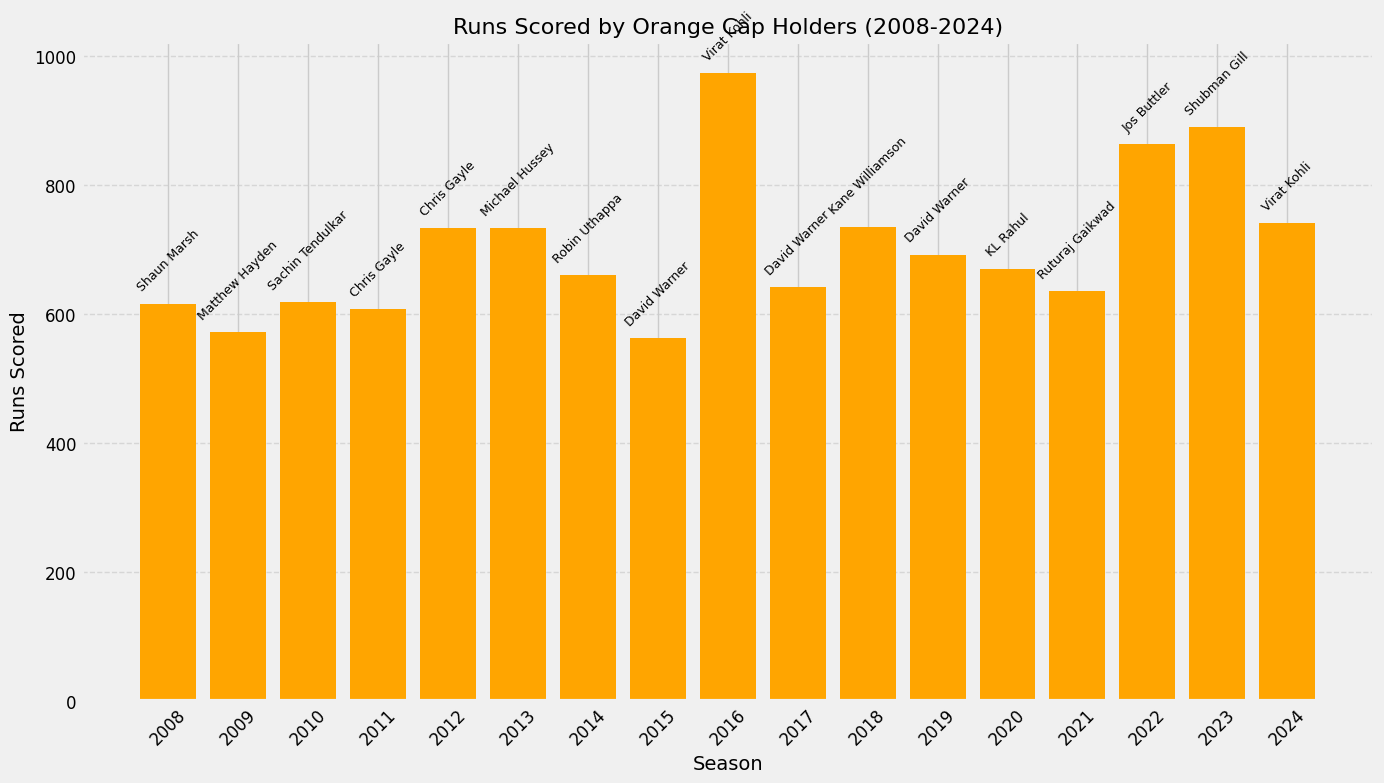

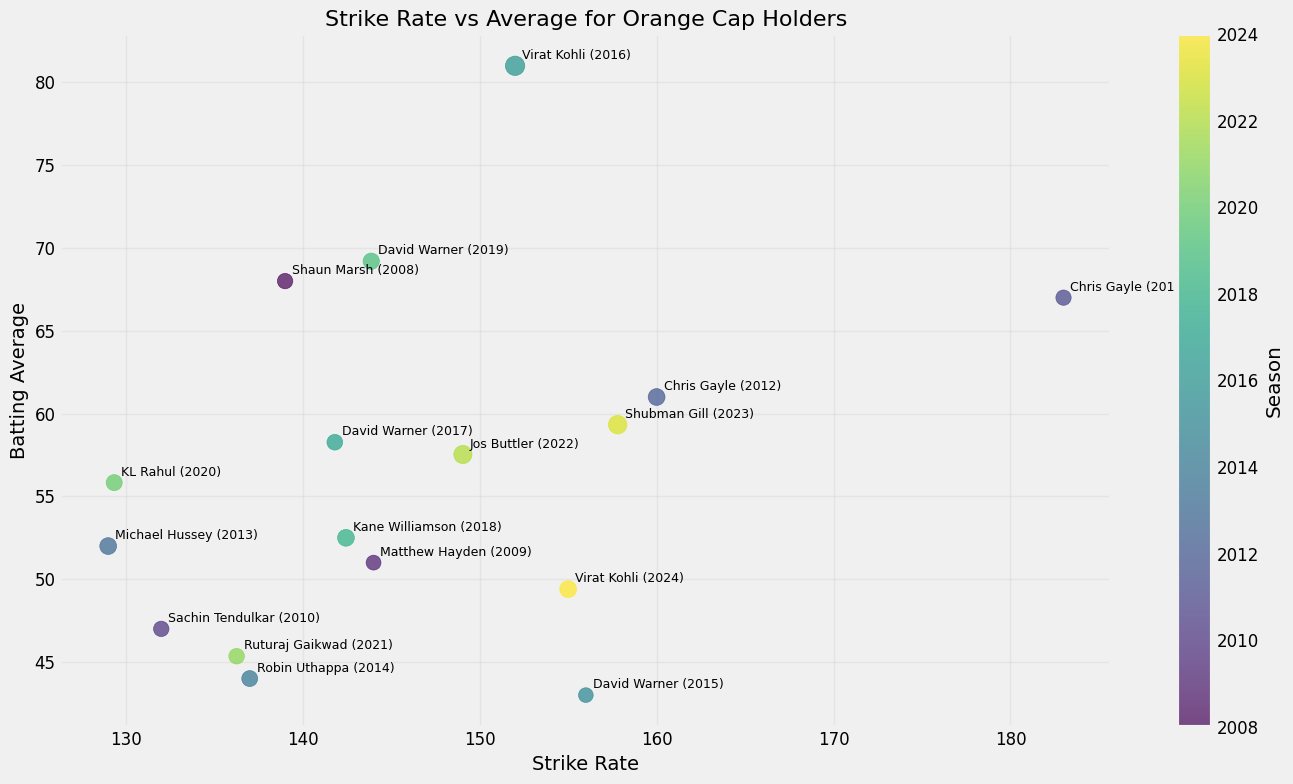

In [100]:
# Ensure season column exists
if 'season' not in matches.columns:
    matches['season'] = pd.to_datetime(matches['date']).dt.year

# Orange Cap Analysis
orange_cap_analysis()


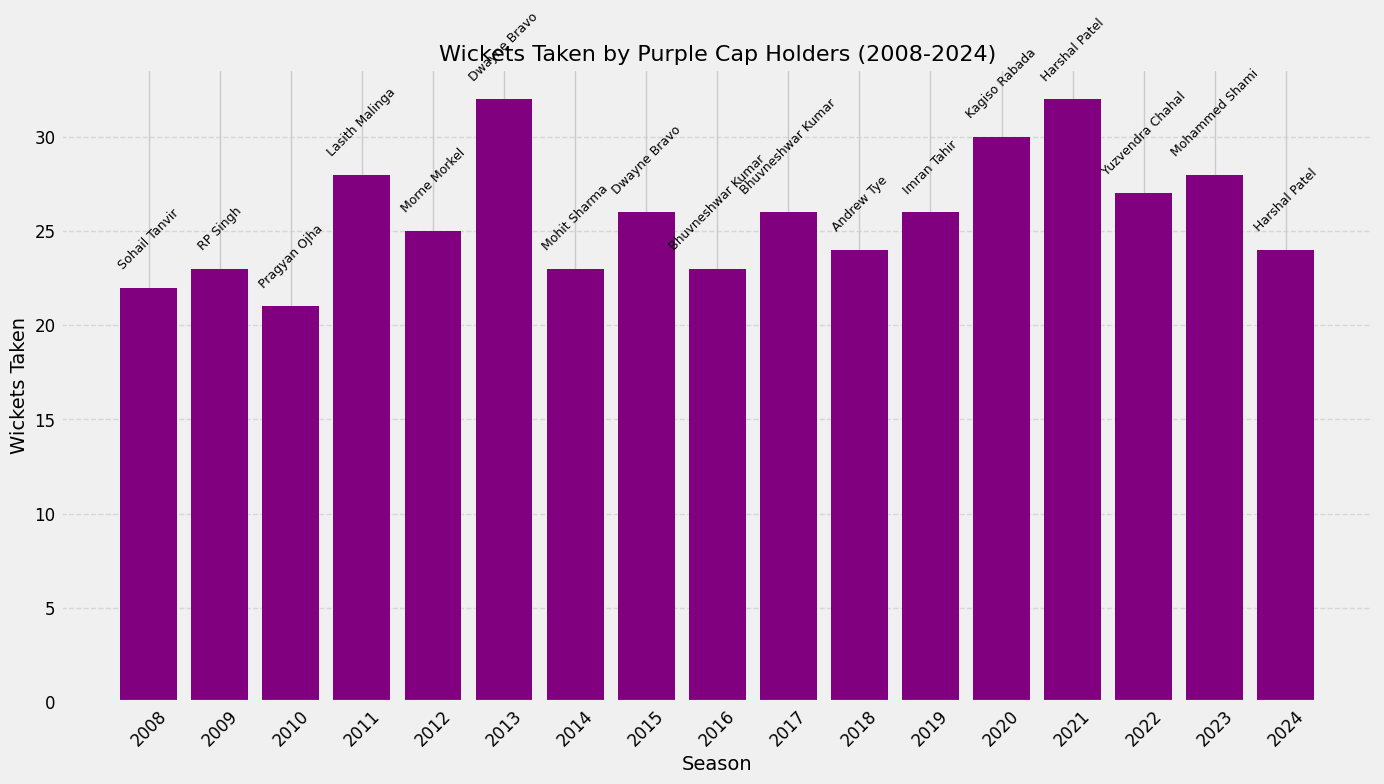

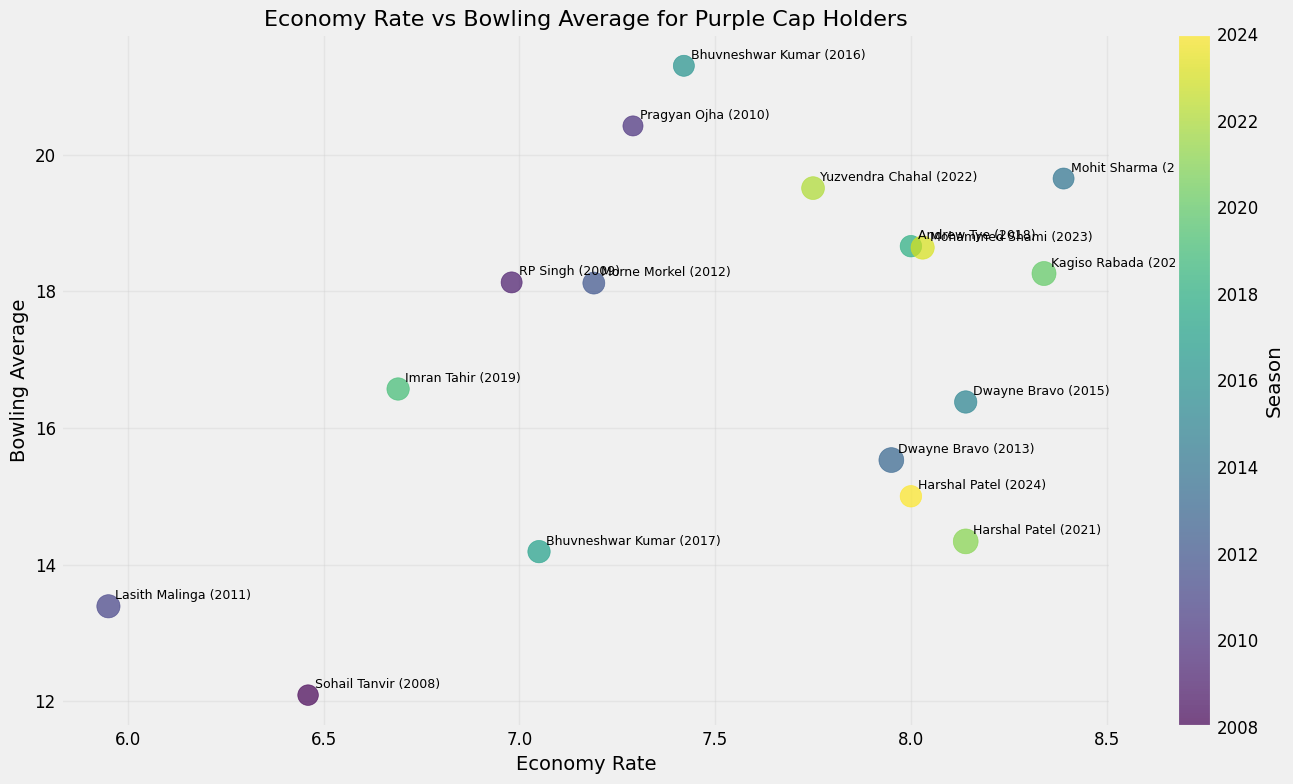

In [101]:

# Purple Cap Analysis
purple_cap_analysis()


In [111]:
def plot_top_bowlers(top_bowlers, season):
    # Create a directory for plots if it doesn't exist
    import os
    # Create a safe filename
    safe_season = str(season).replace('/', '_')
    
    plt.figure(figsize=(14, 8))
    bars = plt.bar(top_bowlers['bowler'], top_bowlers['wickets'], color='purple')
    
    # Add economy rate as text on bars
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                 f"Econ: {top_bowlers['economy'].iloc[i]}", ha='center', fontsize=9)
    
    plt.xlabel('Bowler', fontsize=14)
    plt.ylabel('Wickets', fontsize=14)
    plt.title(f'Top 10 Bowlers in IPL {season}', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'top_bowlers_{safe_season}.png')
    plt.show()


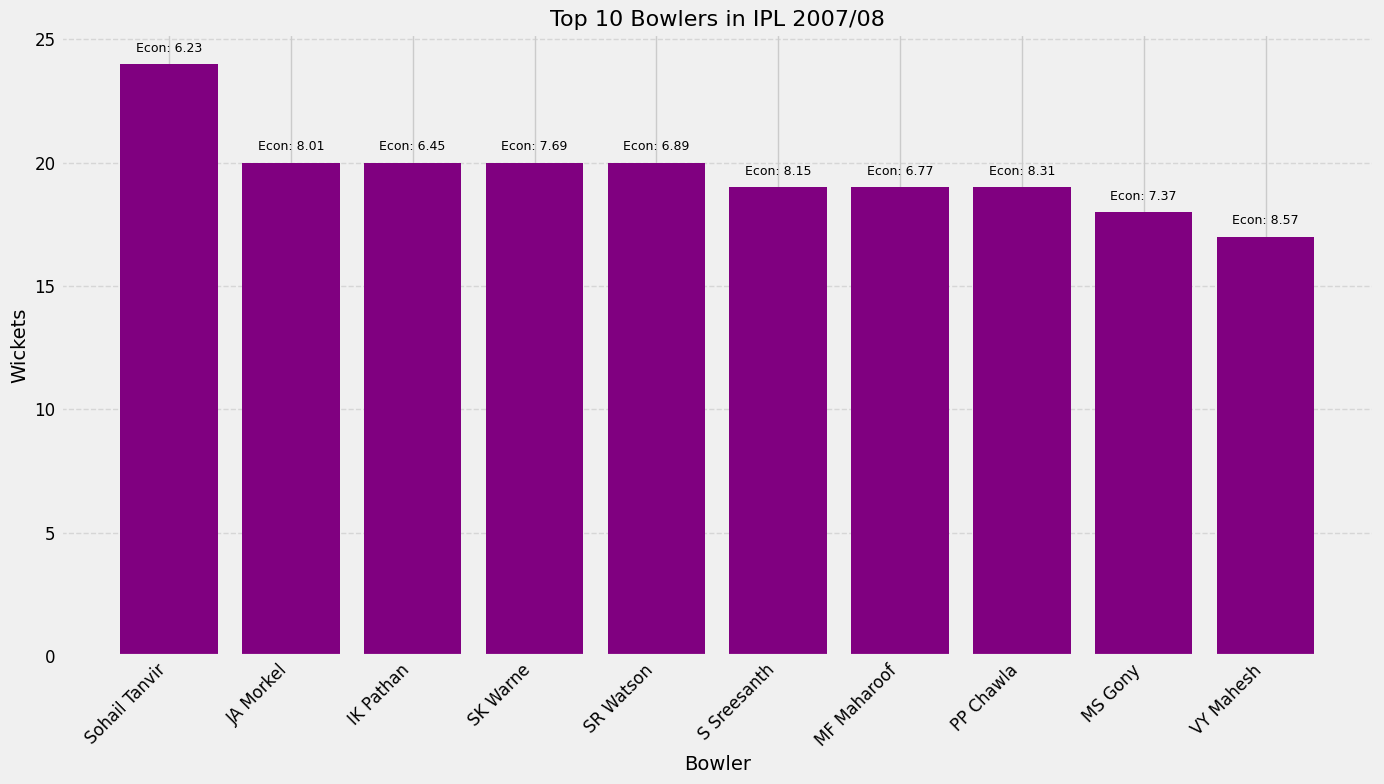

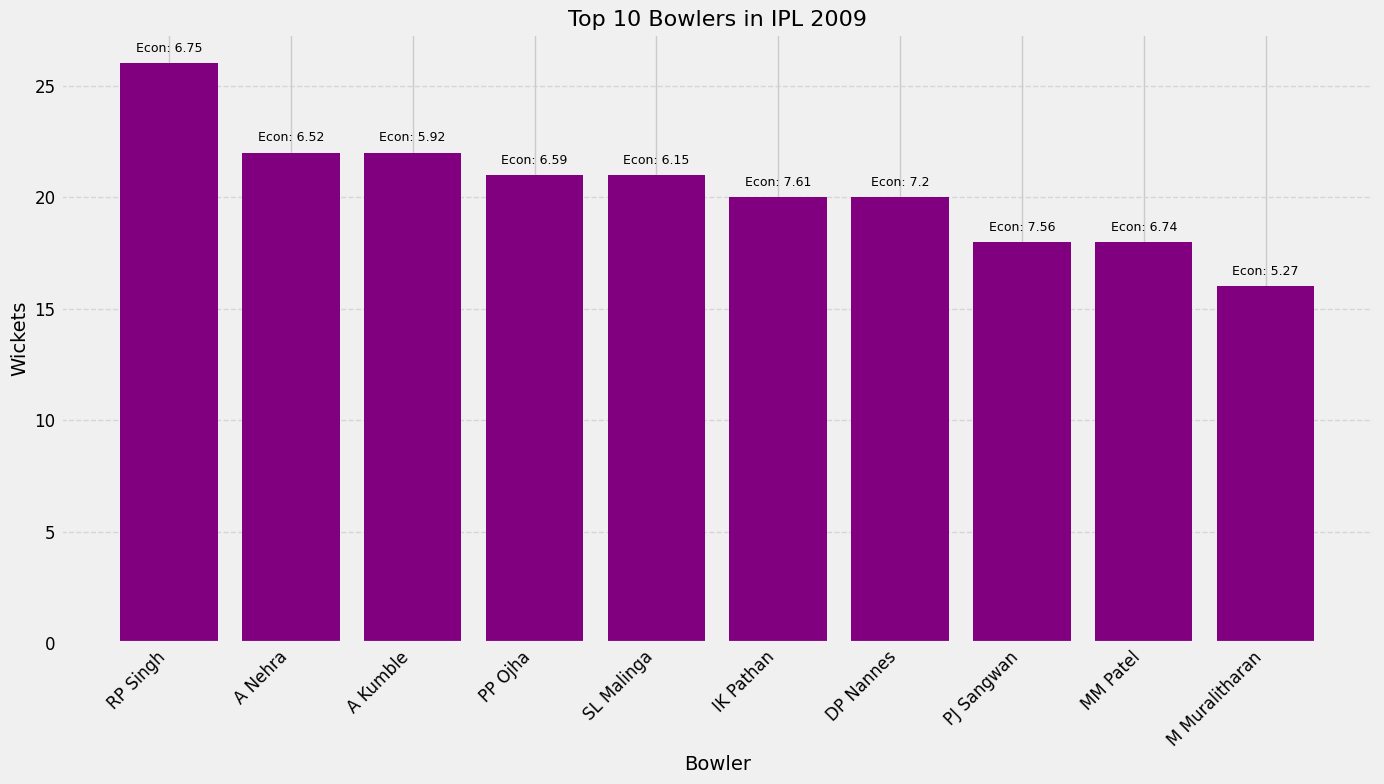

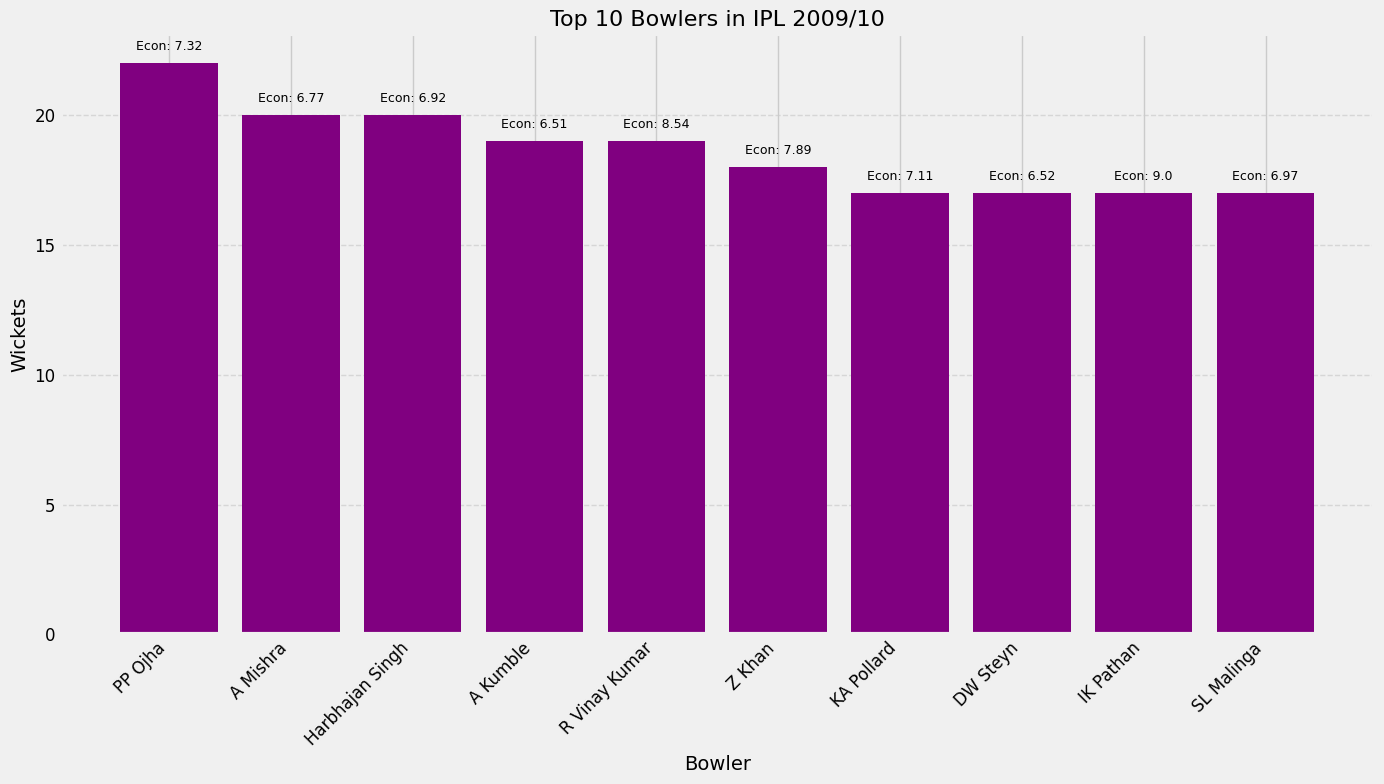

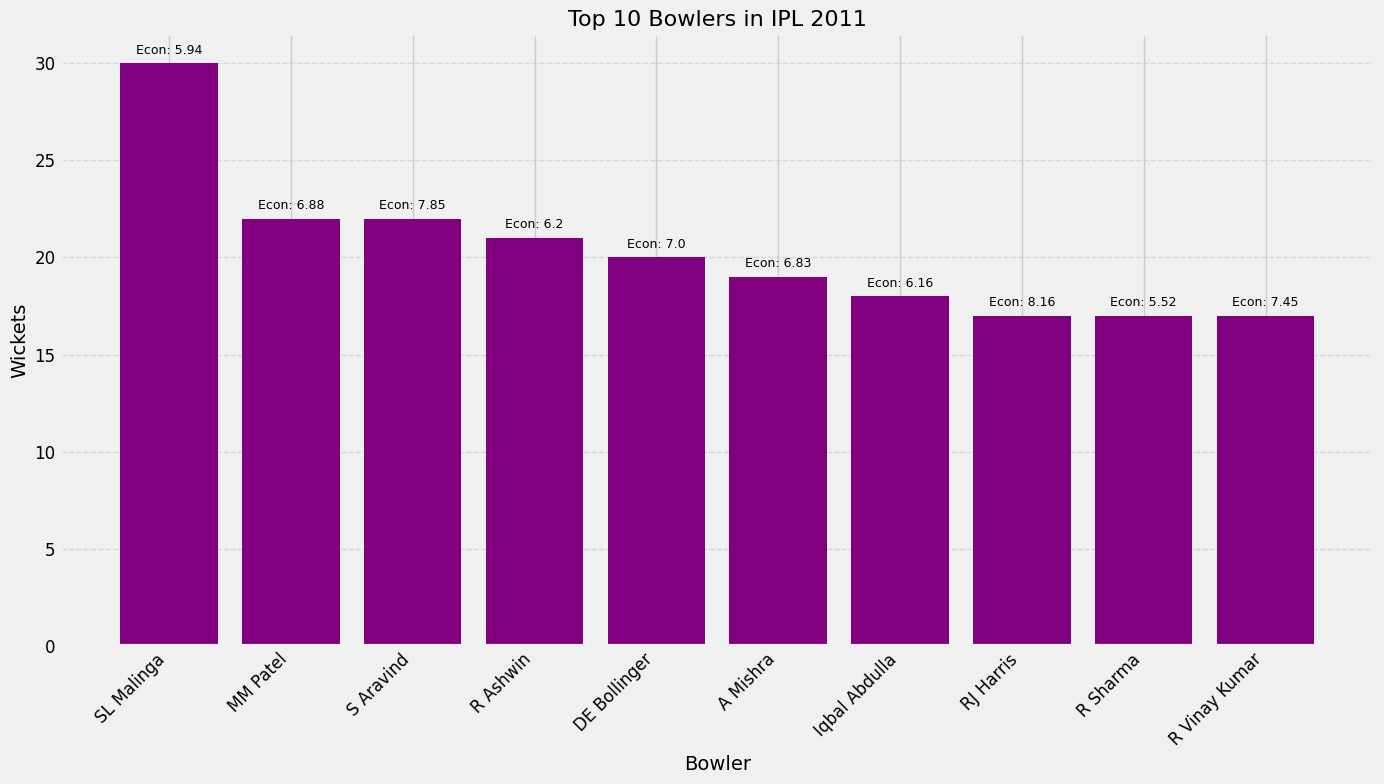

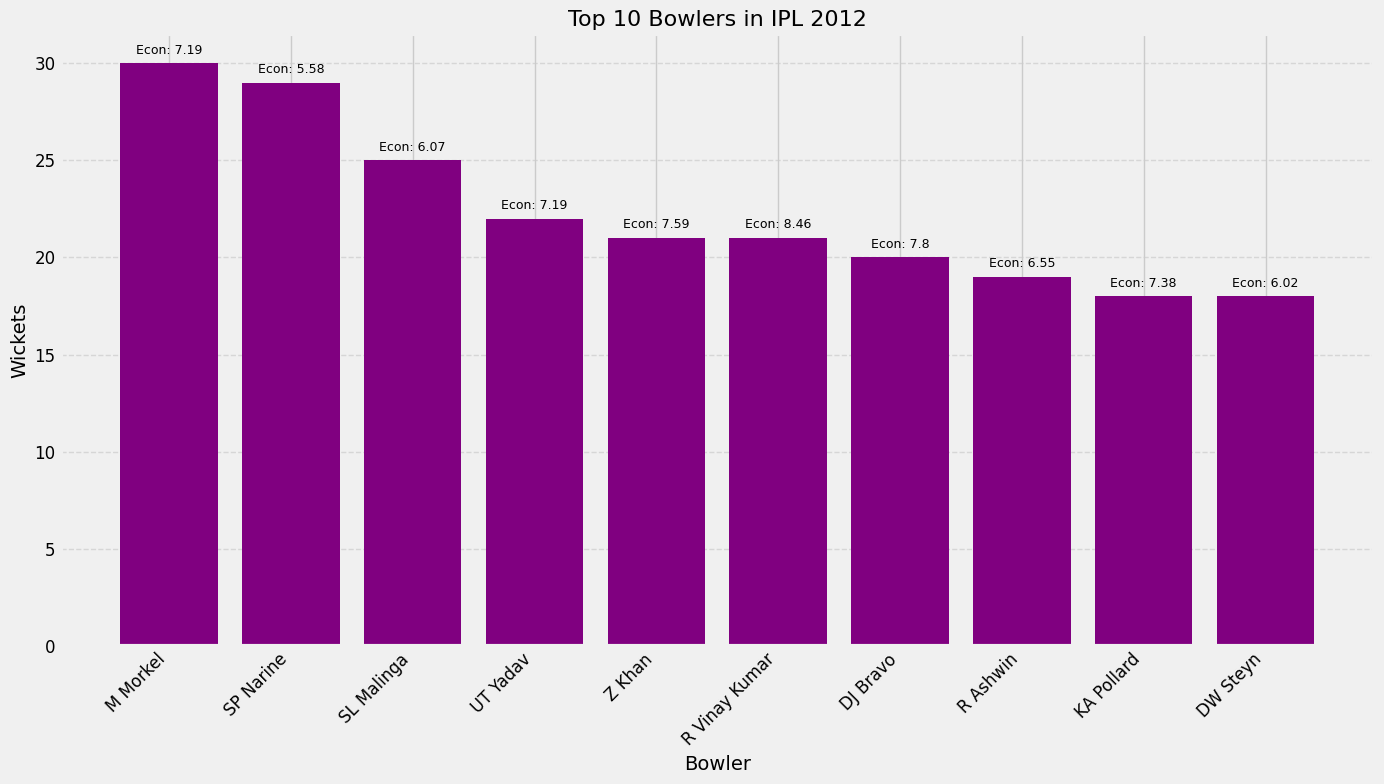

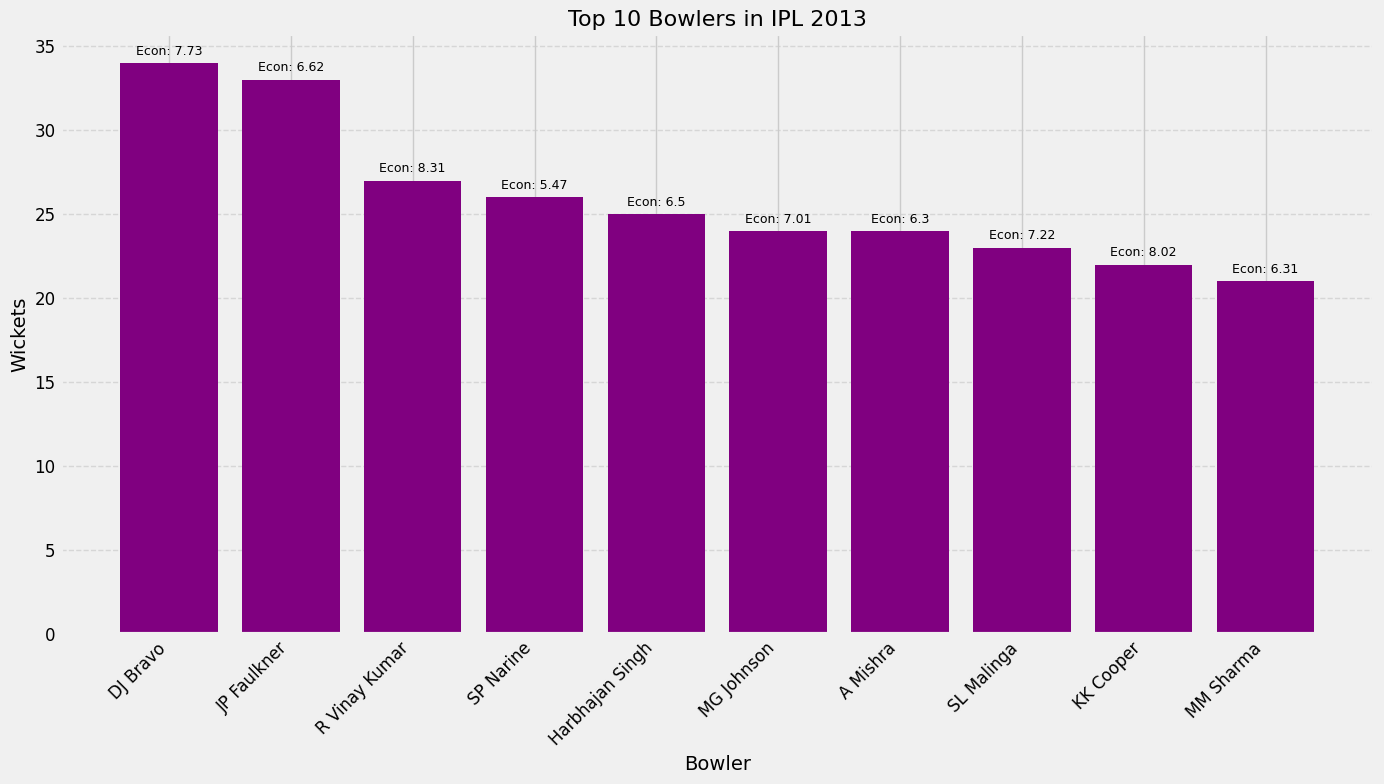

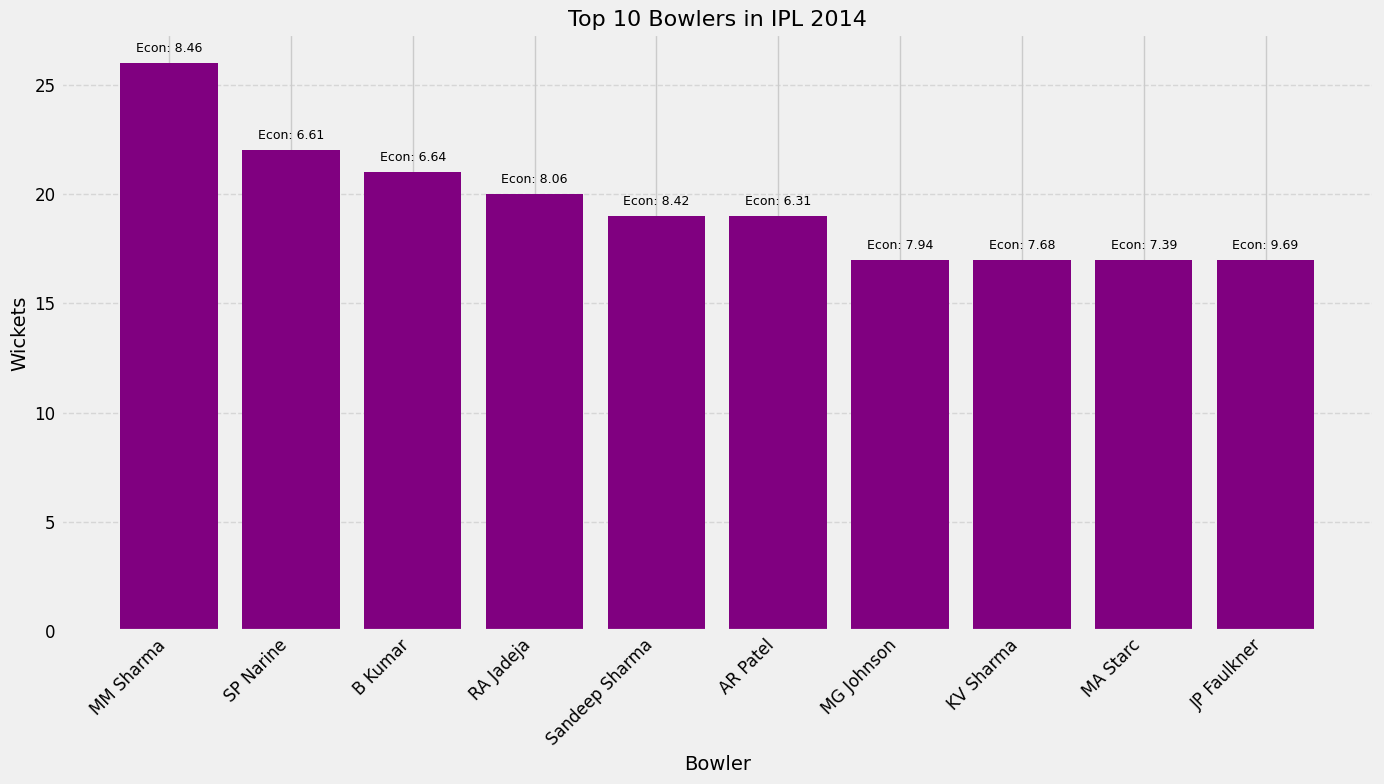

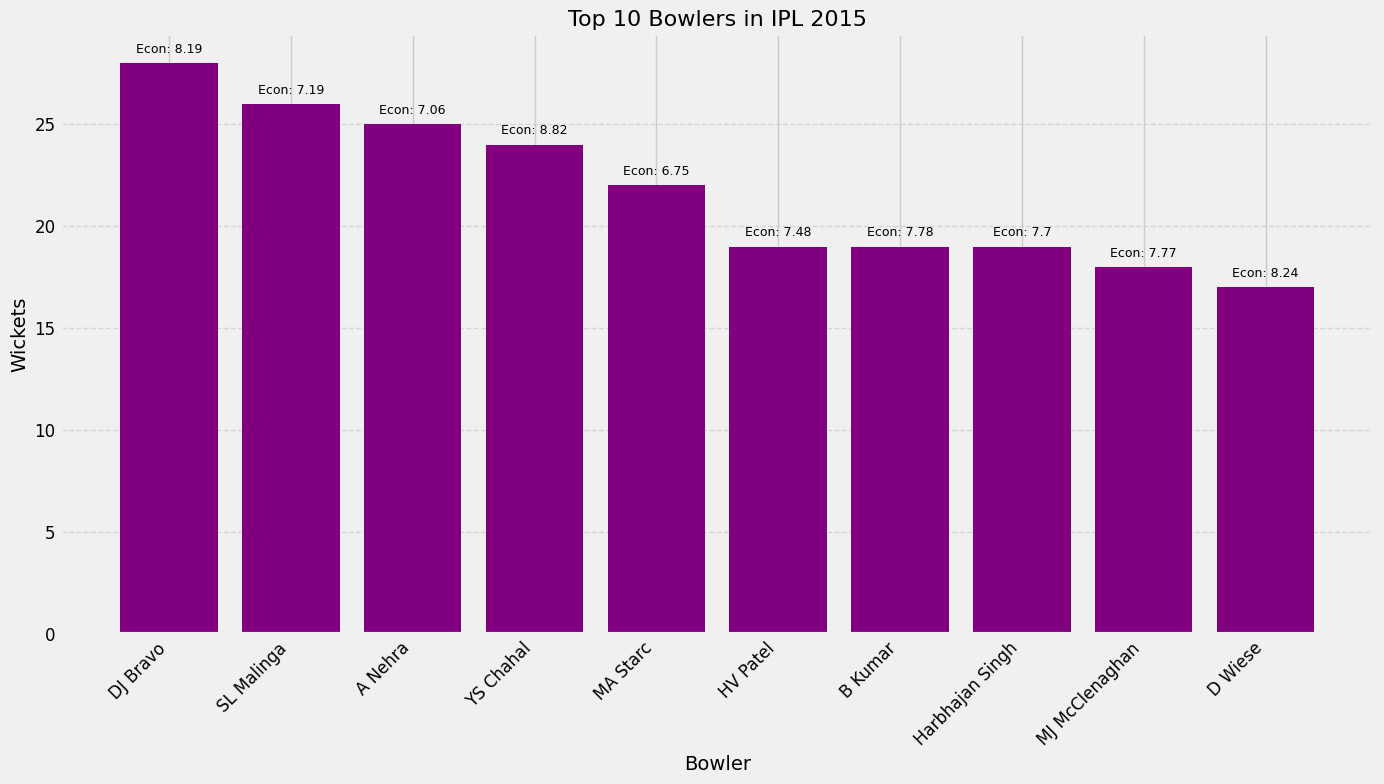

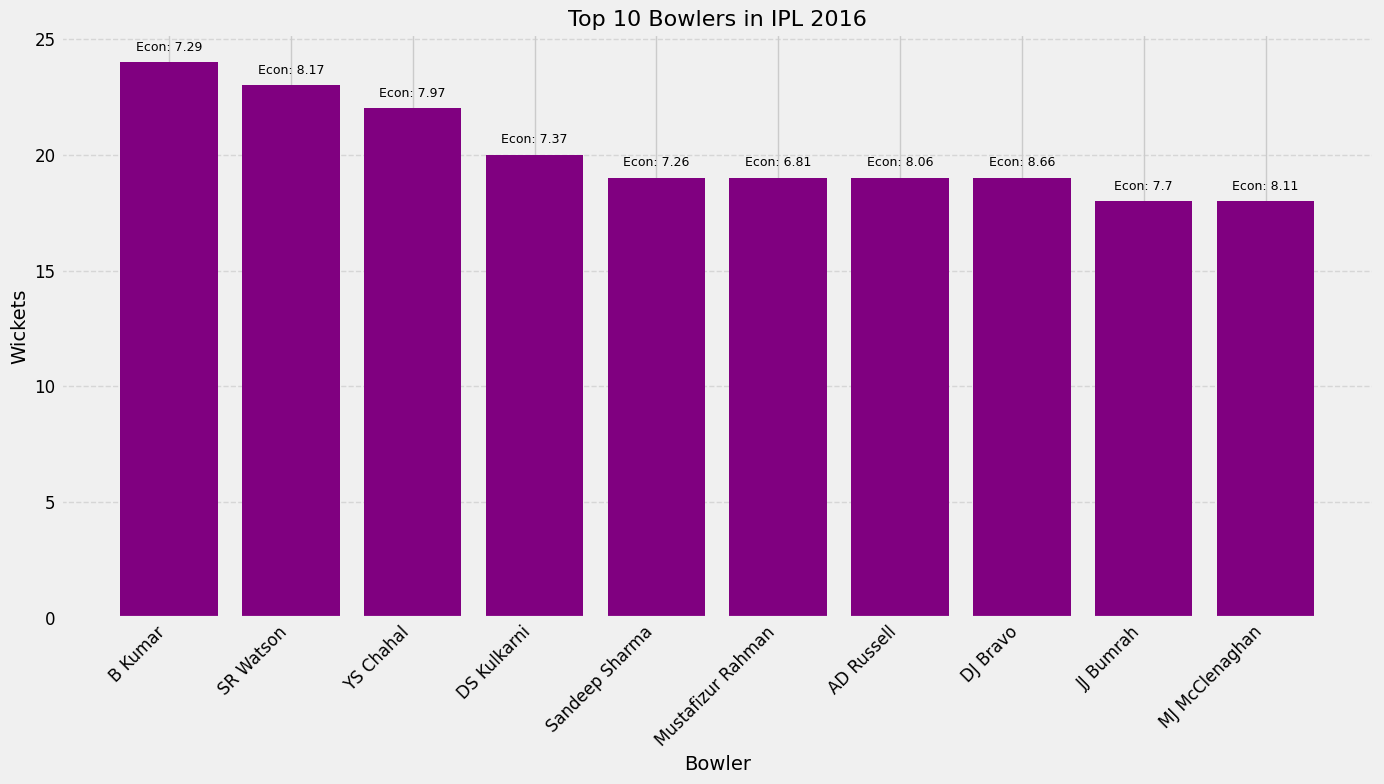

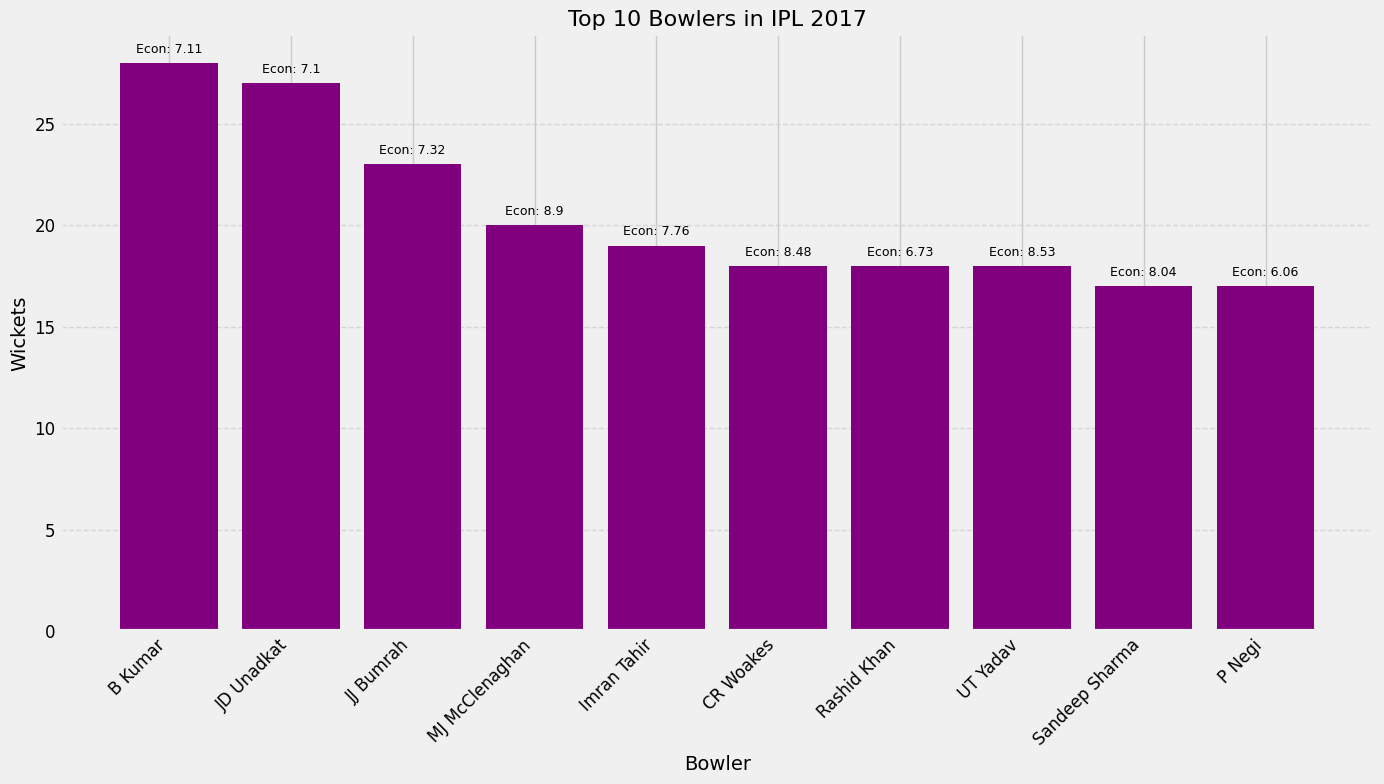

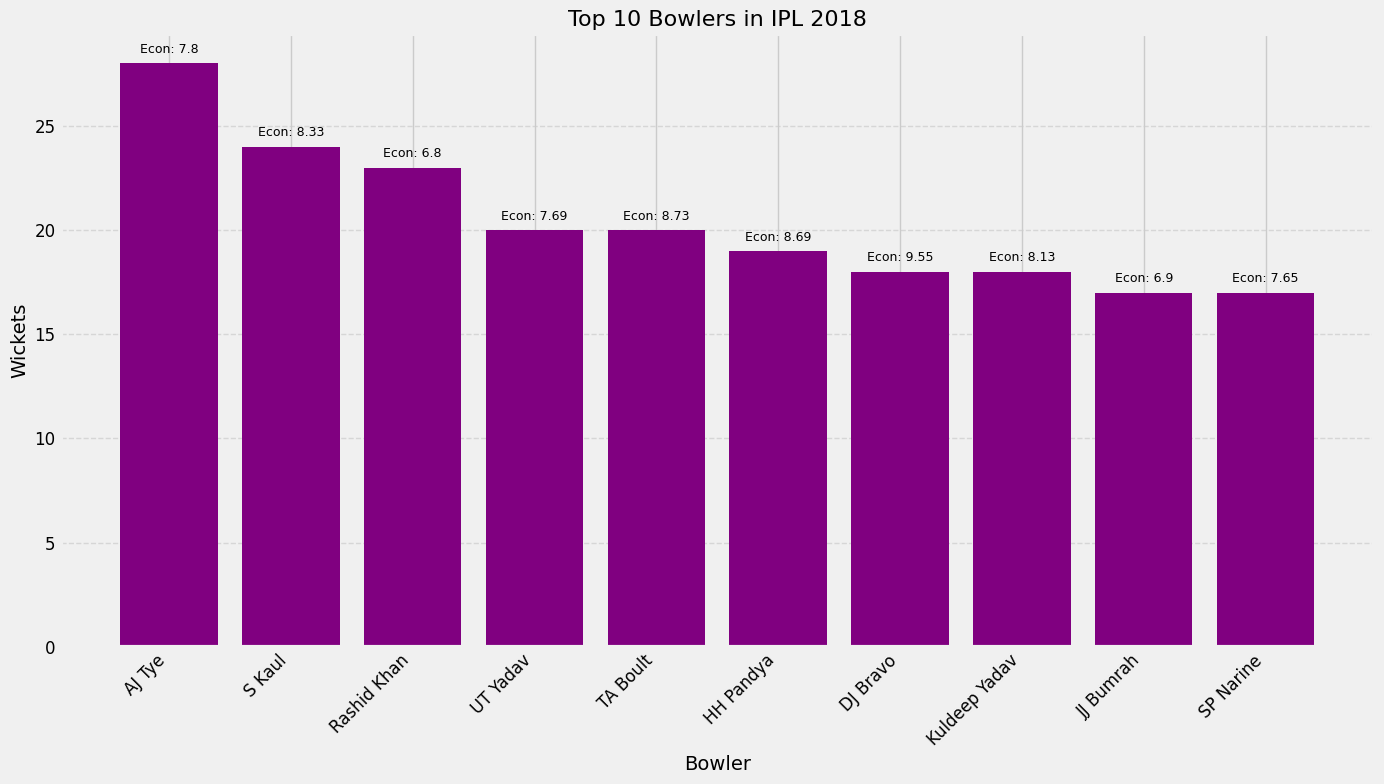

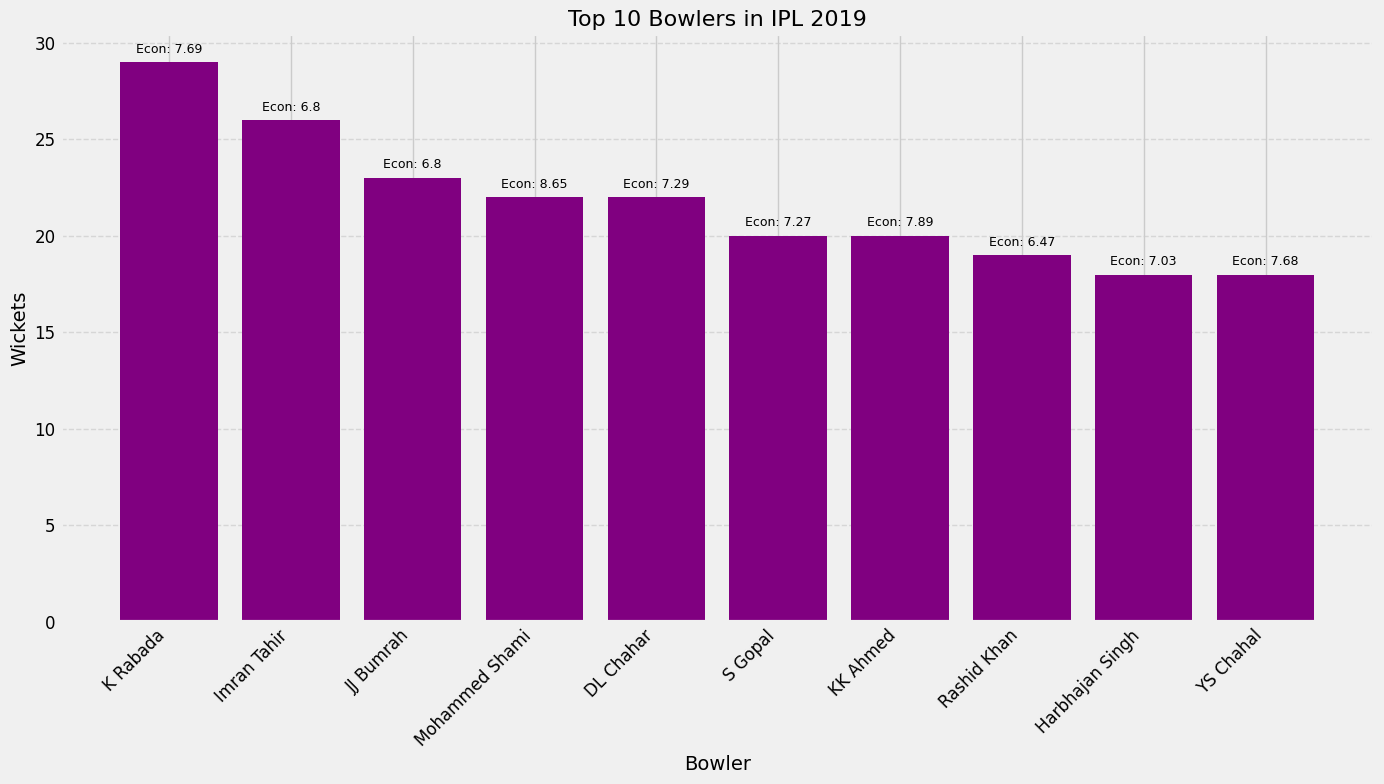

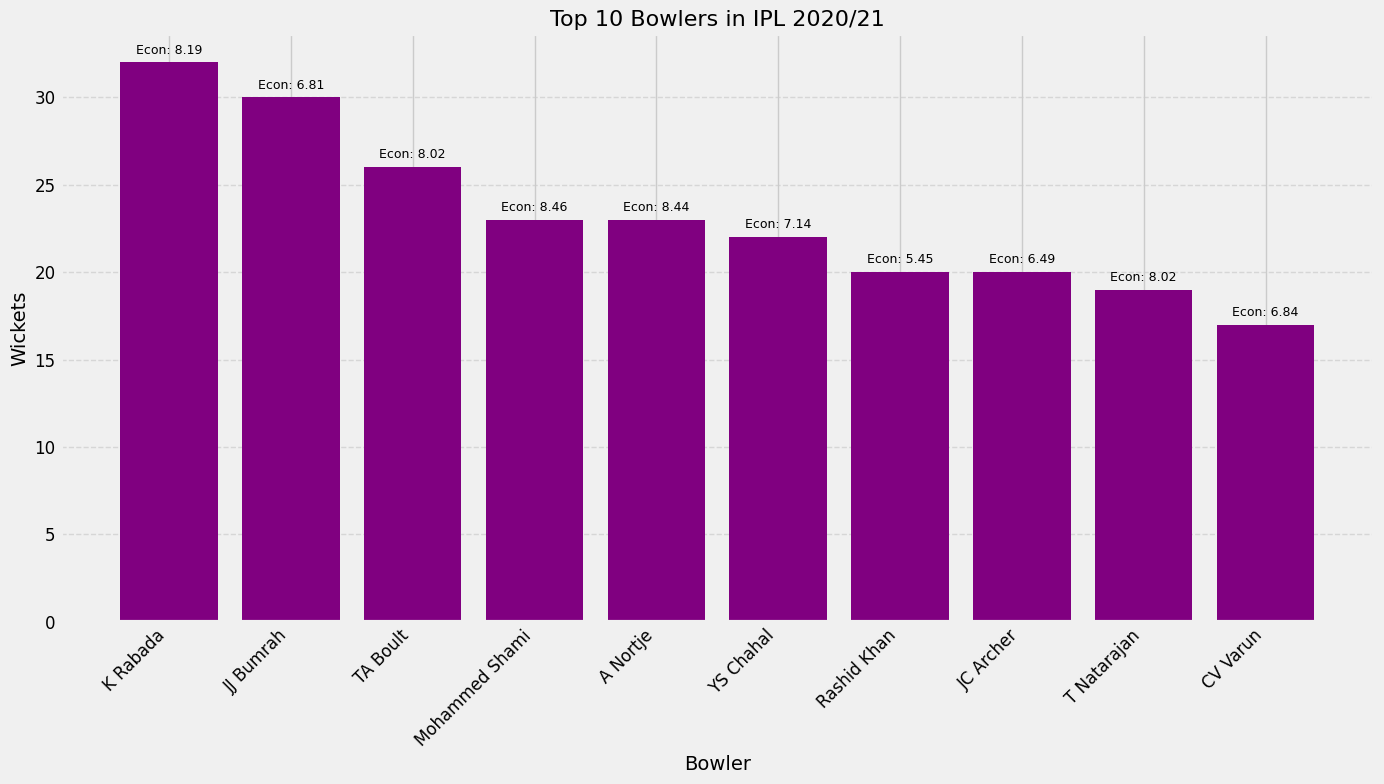

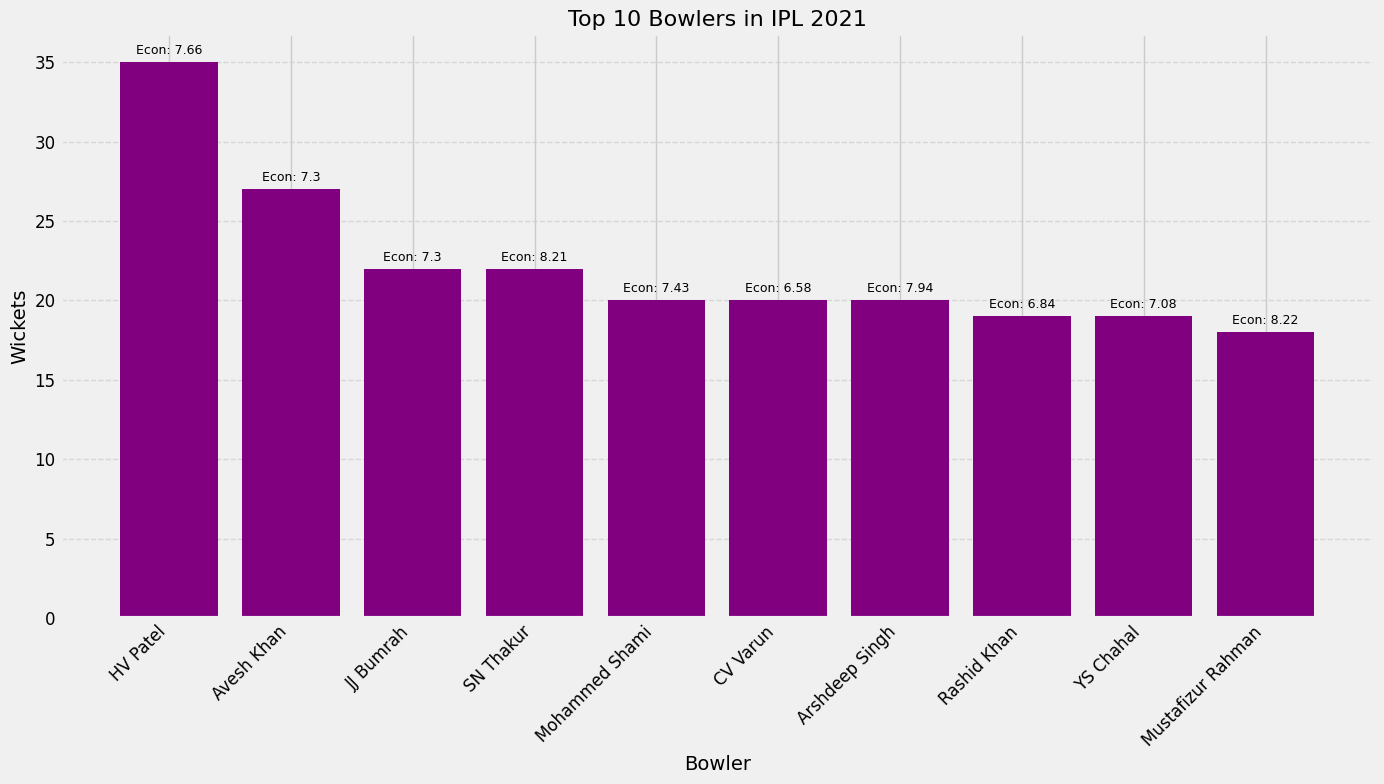

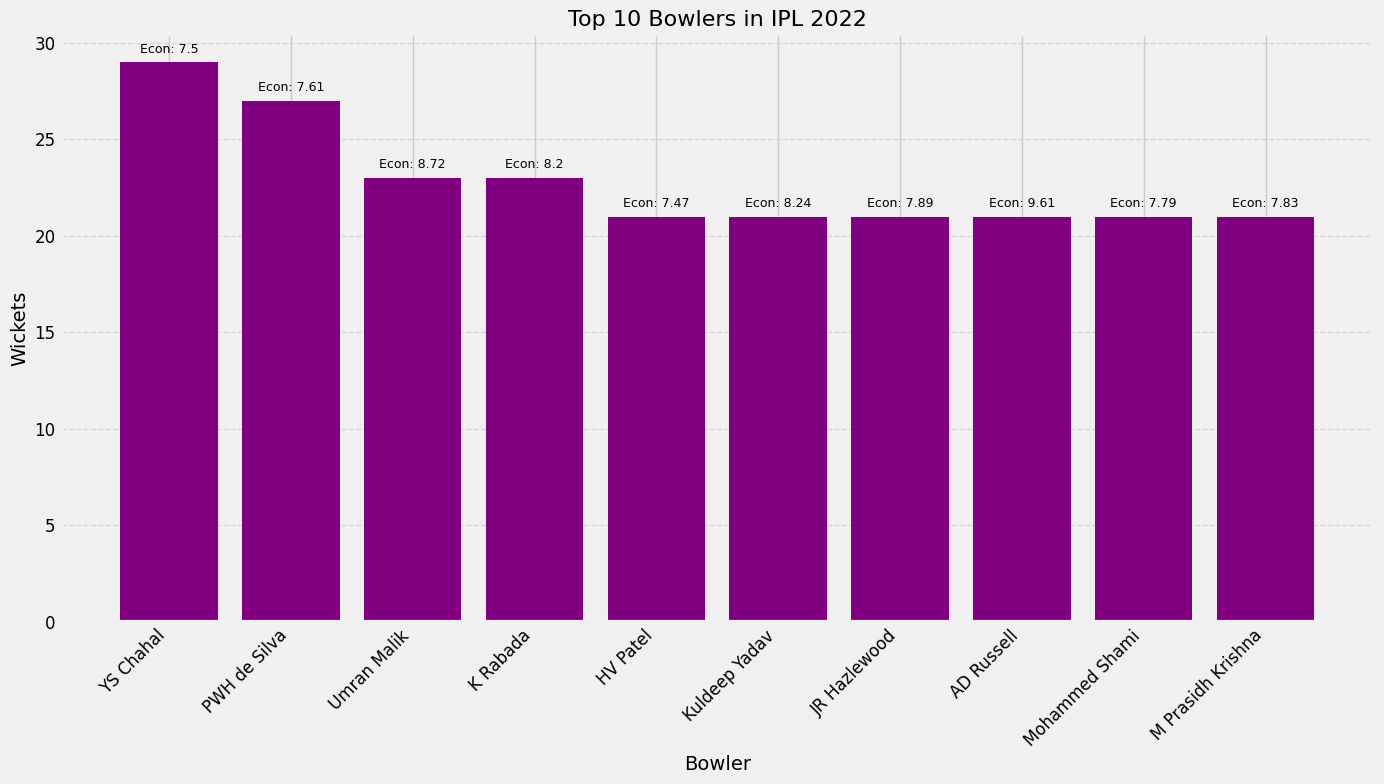

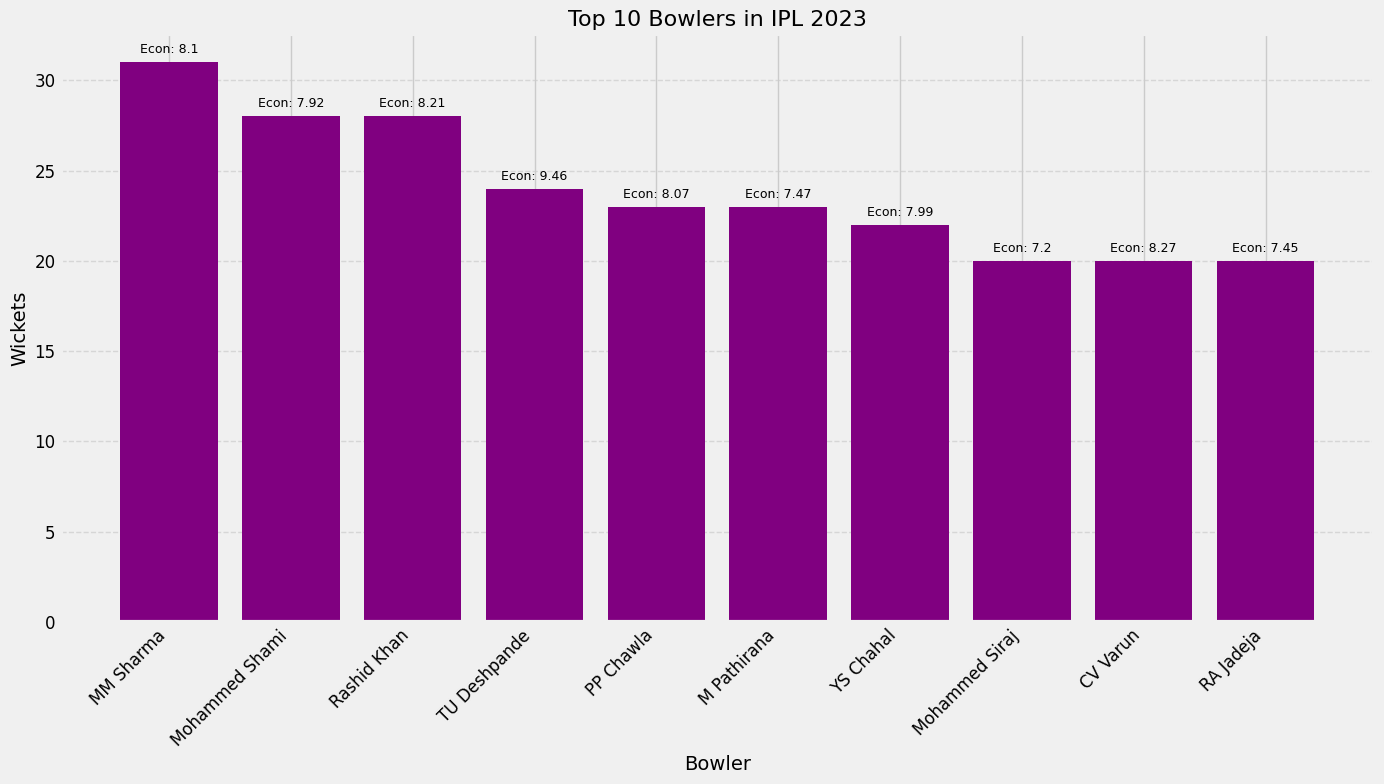

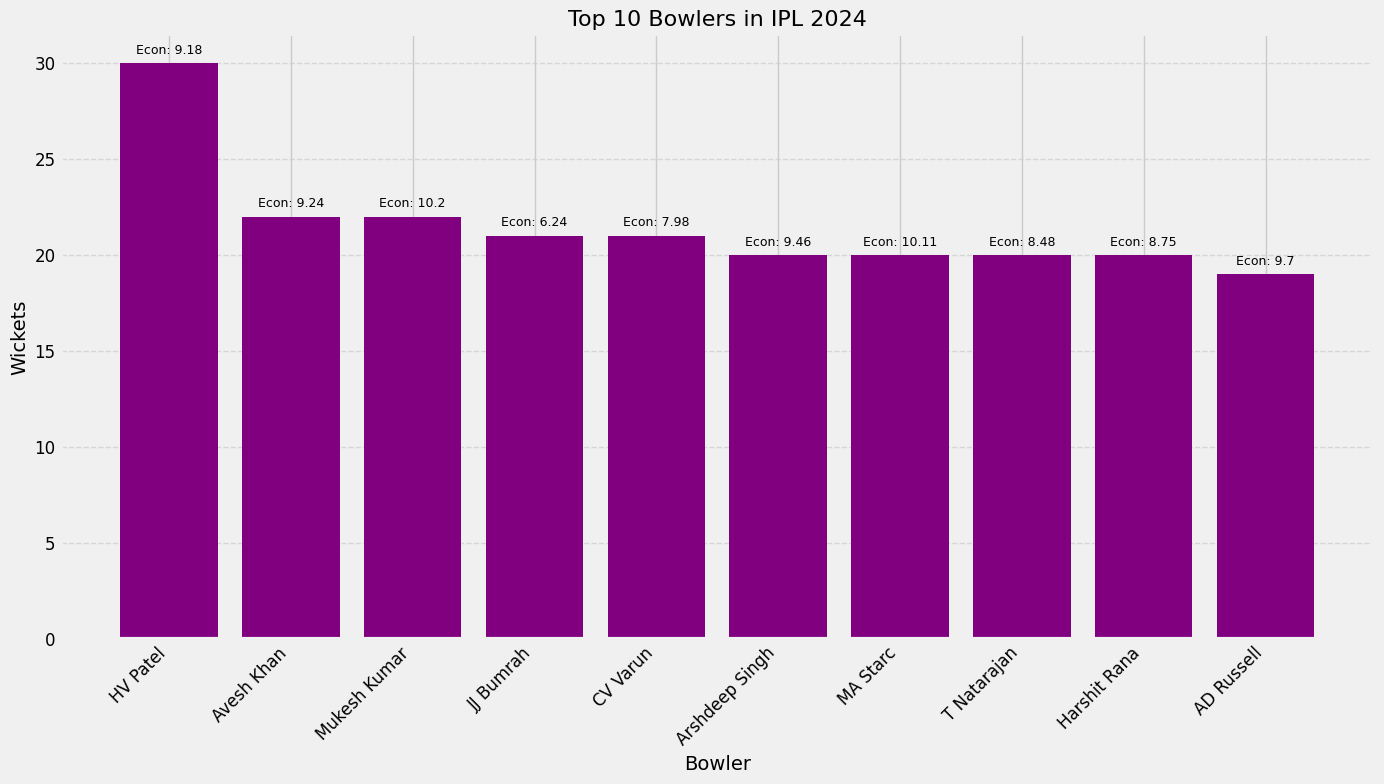

In [ ]:
# Top Bowlers Analysis
all_top_bowlers = analyze_top_bowlers_all_seasons(deliveries, matches)
for season, top_bowlers in all_top_bowlers.items():
    plot_top_bowlers(top_bowlers, season)

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
matches = pd.read_csv('matches.csv')

matches.head()

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
1,335983,2007/08,Chandigarh,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,241.0,20.0,N,NaN,MR Benson,SL Shastri
2,335984,2007/08,Delhi,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,130.0,20.0,N,NaN,Aleem Dar,GA Pratapkumar
3,335985,2007/08,Mumbai,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,166.0,20.0,N,NaN,SJ Davis,DJ Harper
4,335986,2007/08,Kolkata,2008-04-20,League,DJ Hussey,Eden Gardens,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,111.0,20.0,N,NaN,BF Bowden,K Hariharan


In [ ]:
deliveries = pd.read_csv('deliveries.csv')
deliveries.head()

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,1,wides,0,NaN,NaN,NaN
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN


In [ ]:
deliveries['ball'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [ ]:
ball_faced = deliveries.groupby('batter')['ball'].count() 

ball_face_batsman = ball_faced[ball_faced > 100].reset_index().sort_values(by='batter').rename(columns={'ball':'ball_faced'})

ball_face_batsman

,batter,ball_faced
0,A Ashish Reddy,196
1,A Badoni,505
2,A Manohar,181
3,A Mishra,440
4,A Raghuvanshi,109
...,...,...
294,YBK Jaiswal,1095
295,YK Pathan,2334
296,YV Takawale,183
297,Yuvraj Singh,2207


In [ ]:
len(ball_face_batsman['batter'].unique())

299

In [ ]:
correct_batsmen  = deliveries[deliveries['batter'].isin(ball_face_batsman['batter'])]
correct_batsmen

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,1,wides,0,NaN,NaN,NaN
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260915,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,5,SS Iyer,AK Markram,VR Iyer,1,0,1,NaN,0,NaN,NaN,NaN
260916,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,6,VR Iyer,AK Markram,SS Iyer,1,0,1,NaN,0,NaN,NaN,NaN
260917,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,1,VR Iyer,Shahbaz Ahmed,SS Iyer,1,0,1,NaN,0,NaN,NaN,NaN
260918,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,2,SS Iyer,Shahbaz Ahmed,VR Iyer,1,0,1,NaN,0,NaN,NaN,NaN


In [ ]:
correct_batsmen.shape

(249886, 17)

In [ ]:
correct_batsmen['total_runs'].unique()

array([1, 0, 4, 6, 5, 2, 3, 7])

In [ ]:
total_runs = correct_batsmen.groupby('batter')['batsman_runs'].sum().reset_index().sort_values(by='batter')

total_runs

,batter,batsman_runs
0,A Ashish Reddy,280
1,A Badoni,634
2,A Manohar,231
3,A Mishra,381
4,A Raghuvanshi,163
...,...,...
294,YBK Jaiswal,1607
295,YK Pathan,3222
296,YV Takawale,192
297,Yuvraj Singh,2754


In [ ]:
batter_out = correct_batsmen[correct_batsmen['is_wicket'] == 1]['batter'].value_counts().reset_index().sort_values(by='batter').rename(columns={'count':'num_times_out'})
batter_out

,batter,num_times_out
196,A Ashish Reddy,15
142,A Badoni,26
205,A Manohar,14
113,A Mishra,31
275,A Raghuvanshi,7
...,...,...
78,YBK Jaiswal,49
24,YK Pathan,111
261,YV Takawale,8
25,Yuvraj Singh,109


In [ ]:
merge = ball_face_batsman.merge(total_runs, on='batter', how='inner').merge(batter_out, on='batter', how='inner')
merge

,batter,ball_faced,batsman_runs,num_times_out
0,A Ashish Reddy,196,280,15
1,A Badoni,505,634,26
2,A Manohar,181,231,14
3,A Mishra,440,381,31
4,A Raghuvanshi,109,163,7
...,...,...,...,...
294,YBK Jaiswal,1095,1607,49
295,YK Pathan,2334,3222,111
296,YV Takawale,183,192,8
297,Yuvraj Singh,2207,2754,109


In [ ]:
merge['batting_avg'] = merge['batsman_runs'] / merge['num_times_out']
merge['strike_rate'] = (merge['batsman_runs'] / merge['ball_faced']) * 100
#merge['bowling_eco'] = merge['batsman_runs'] / merge['over']

merge

,batter,ball_faced,batsman_runs,num_times_out,batting_avg,strike_rate
0,A Ashish Reddy,196,280,15,18.666667,142.857143
1,A Badoni,505,634,26,24.384615,125.544554
2,A Manohar,181,231,14,16.500000,127.624309
3,A Mishra,440,381,31,12.290323,86.590909
4,A Raghuvanshi,109,163,7,23.285714,149.541284
...,...,...,...,...,...,...
294,YBK Jaiswal,1095,1607,49,32.795918,146.757991
295,YK Pathan,2334,3222,111,29.027027,138.046272
296,YV Takawale,183,192,8,24.000000,104.918033
297,Yuvraj Singh,2207,2754,109,25.266055,124.784776


In [ ]:
deliveries['bowler'].value_counts()

bowler
R Ashwin         4679
SP Narine        4146
B Kumar          4060
RA Jadeja        3895
PP Chawla        3895
                 ... 
SN Khan             2
SPD Smith           2
AC Gilchrist        1
YBK Jaiswal         1
Atharva Taide       1
Name: count, Length: 530, dtype: int64

In [ ]:
# Calculate overs bowled
overs_bowled = deliveries.groupby('bowler').size() / 6

# Create a dataframe with bowlers and overs bowled
bowler_overs = pd.DataFrame({
    'bowler': overs_bowled.index,
    'over': overs_bowled.values.round(1)  # Round to 1 decimal place
})

# Sort by overs bowled in descending order
bowler_overs = bowler_overs.sort_values('over', ascending=False).reset_index(drop=True)

# Display the top 10 bowlers by overs bowled
print(bowler_overs.head(10))

            bowler   over
0         R Ashwin  779.8
1        SP Narine  691.0
2          B Kumar  676.7
3        PP Chawla  649.2
4        RA Jadeja  649.2
5        YS Chahal  604.7
6  Harbhajan Singh  582.7
7         A Mishra  574.0
8         DJ Bravo  549.3
9         UT Yadav  531.7


In [ ]:
len(bowler_overs['bowler'].unique())

530

In [ ]:
eligible_df  = deliveries[deliveries['bowler'].isin(bowler_overs['bowler'])]
eligible_df

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,1,wides,0,NaN,NaN,NaN
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260915,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,5,SS Iyer,AK Markram,VR Iyer,1,0,1,NaN,0,NaN,NaN,NaN
260916,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,9,6,VR Iyer,AK Markram,SS Iyer,1,0,1,NaN,0,NaN,NaN,NaN
260917,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,1,VR Iyer,Shahbaz Ahmed,SS Iyer,1,0,1,NaN,0,NaN,NaN,NaN
260918,1426312,2,Kolkata Knight Riders,Sunrisers Hyderabad,10,2,SS Iyer,Shahbaz Ahmed,VR Iyer,1,0,1,NaN,0,NaN,NaN,NaN


In [ ]:
eligible_df.shape
eligible_df['total_runs'].unique()

array([1, 0, 4, 6, 5, 2, 3, 7])

In [ ]:
total_runs = eligible_df.groupby('bowler')['total_runs'].sum().reset_index().sort_values(by='bowler')
total_runs

,bowler,total_runs
0,A Ashish Reddy,400
1,A Badoni,37
2,A Chandila,245
3,A Choudhary,144
4,A Dananjaya,47
...,...,...
525,Yash Dayal,933
526,Yash Thakur,702
527,Yudhvir Singh,125
528,Yuvraj Singh,1091


In [ ]:
merged_df = bowler_overs.merge(total_runs, on='bowler', how='inner')
merged_df['bowling_eco'] = merged_df['total_runs'] / merged_df['over']
merged_df

,bowler,over,total_runs,bowling_eco
0,R Ashwin,779.8,5435,6.969736
1,SP Narine,691.0,4672,6.761216
2,B Kumar,676.7,5051,7.464164
3,PP Chawla,649.2,5179,7.977511
4,RA Jadeja,649.2,4917,7.573937
...,...,...,...,...
525,DA Warner,0.3,2,6.666667
526,SN Khan,0.3,6,20.000000
527,YBK Jaiswal,0.2,6,30.000000
528,Atharva Taide,0.2,4,20.000000


In [ ]:
merge

,batter,ball_faced,batsman_runs,num_times_out,batting_avg,strike_rate
0,A Ashish Reddy,196,280,15,18.666667,142.857143
1,A Badoni,505,634,26,24.384615,125.544554
2,A Manohar,181,231,14,16.500000,127.624309
3,A Mishra,440,381,31,12.290323,86.590909
4,A Raghuvanshi,109,163,7,23.285714,149.541284
...,...,...,...,...,...,...
294,YBK Jaiswal,1095,1607,49,32.795918,146.757991
295,YK Pathan,2334,3222,111,29.027027,138.046272
296,YV Takawale,183,192,8,24.000000,104.918033
297,Yuvraj Singh,2207,2754,109,25.266055,124.784776


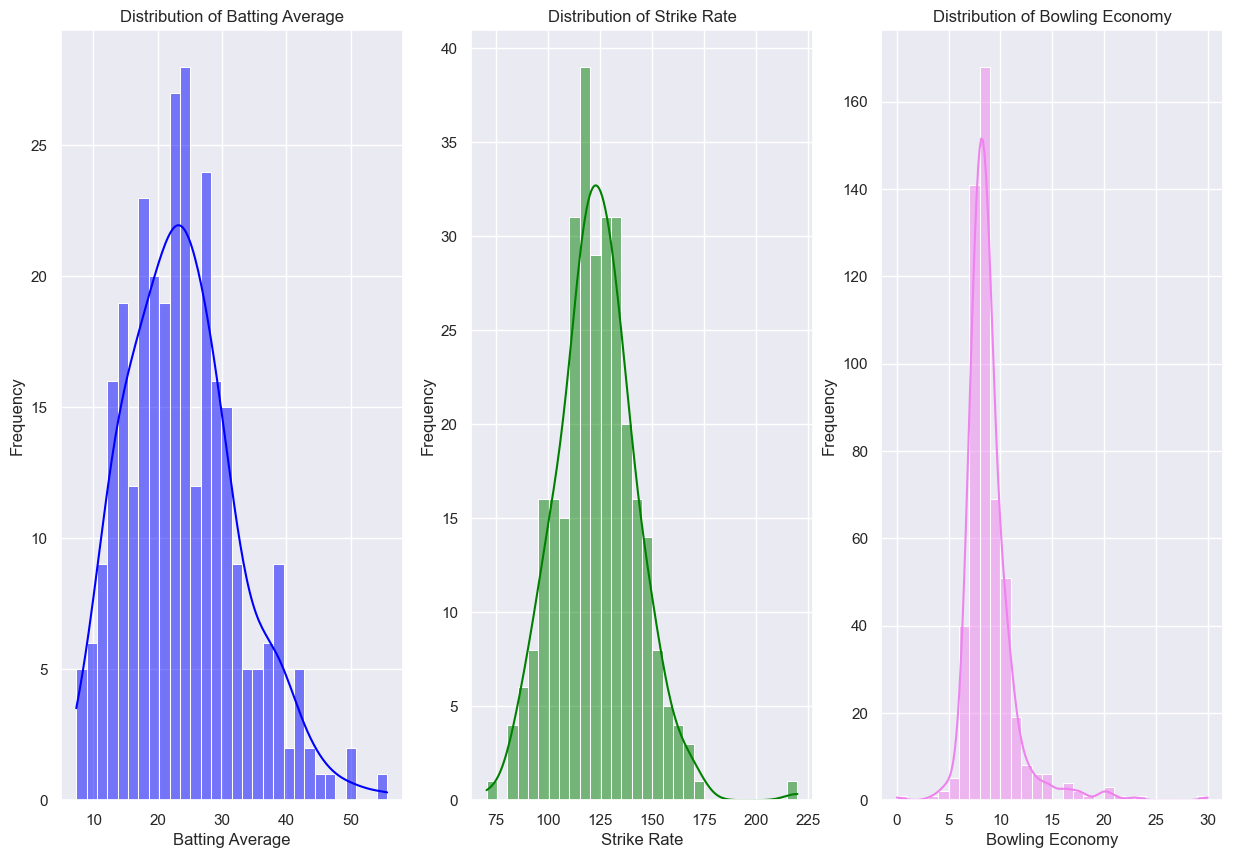

In [ ]:
# Set plot style
sns.set_theme(style="darkgrid")

# Create subplots for Batting Average and Strike Rate distributions
fig, ax = plt.subplots(1, 3, figsize=(15, 10))

# Batting Average Distribution
sns.histplot(data = merge, x = "batting_avg", bins=30, kde=True, ax=ax[0], color="blue")
ax[0].set_title("Distribution of Batting Average")
ax[0].set_xlabel("Batting Average")
ax[0].set_ylabel("Frequency")

# Strike Rate Distribution
sns.histplot(data = merge, x = "strike_rate", bins=30, kde=True, ax=ax[1], color="green")
ax[1].set_title("Distribution of Strike Rate")
ax[1].set_xlabel("Strike Rate")
ax[1].set_ylabel("Frequency")

sns.histplot(data = merged_df, x = "bowling_eco", bins=30, kde=True, ax=ax[2], color="violet")
ax[2].set_title("Distribution of Bowling Economy")
ax[2].set_xlabel("Bowling Economy")
ax[2].set_ylabel("Frequency")

# Show plots
plt.show();

In [ ]:

def remove_outliers(df, column):
    
    Q1 = df[column].quantile(0.25)  # First quartile (25%)
    Q3 = df[column].quantile(0.75)  # Third quartile (75%)
    IQR = Q3 - Q1  # Interquartile Range

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply function to remove outliers from batting_avg and strike_rate
filtered_df = remove_outliers(merge, 'batting_avg')
filtered_df = remove_outliers(filtered_df, 'strike_rate')
filtered_df[filtered_df['batting_avg'] > 40]

,batter,ball_faced,batsman_runs,num_times_out,batting_avg,strike_rate
9,AB de Villiers,3487,5181,125,41.448000,148.580442
61,DA Warner,4849,6567,164,40.042683,135.429986
95,HM Amla,418,577,13,44.384615,138.038278
116,JP Duminy,1680,2029,49,41.408163,120.773810
127,KL Rahul,3578,4689,106,44.235849,131.050866
213,RD Gaikwad,1781,2380,56,42.500000,133.632791
279,Tilak Varma,830,1156,28,41.285714,139.277108


In [ ]:
X = filtered_df.iloc[:,4:6].values
X;

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Transform the data

C:\Users\witby\AppData\Local\Temp\ipykernel_7312\1861002249.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_scaled[:, 0], X_scaled[:, 1], s=50, cmap='viridis')


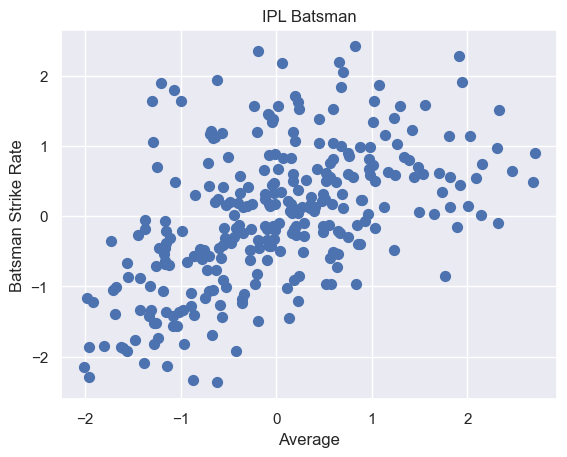

In [ ]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], s=50, cmap='viridis')
plt.title("IPL Batsman")
plt.xlabel("Average")
plt.ylabel("Batsman Strike Rate")
plt.show()

In [ ]:
wcss = []

for i in range(1,11):
    
    kmeans = KMeans(n_init = 10, n_clusters = i)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

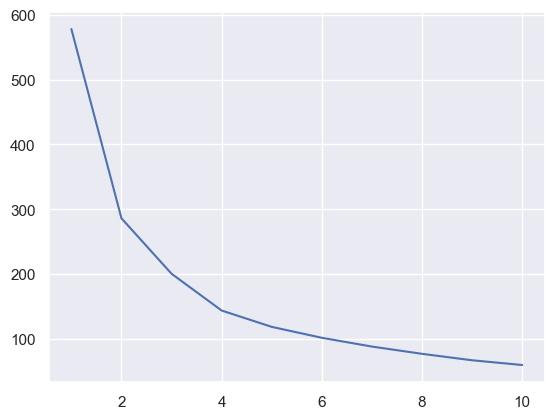

In [ ]:
plt.plot(range(1,11),wcss)

Elbow point at n=4

In [ ]:
kmeans = KMeans(n_init = 20, n_clusters = 4)
y_kmeans = kmeans.fit_predict(X_scaled)


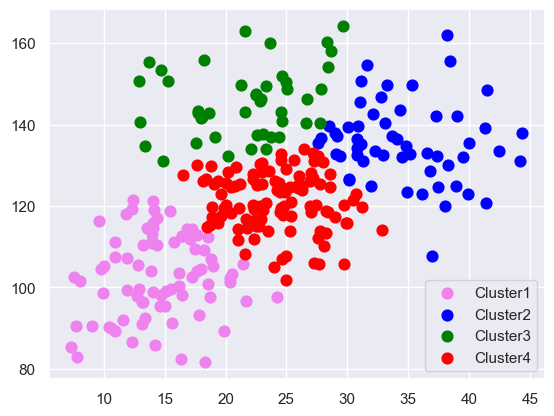

In [ ]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 60, c = 'violet', label = 'Cluster1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 60, c = 'blue', label = 'Cluster2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 60, c = 'green', label = 'Cluster3')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 60, c = 'red', label = 'Cluster4')

plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

for i in range(2, 11):  # Start from 2 instead of 1
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    print(f'For k={i}, Silhouette Score: {score}')

For k=2, Silhouette Score: 0.46964162871855125
For k=3, Silhouette Score: 0.41948374752617984
For k=4, Silhouette Score: 0.3852152541339863
For k=5, Silhouette Score: 0.38118354866647675
For k=6, Silhouette Score: 0.37234223566414354
For k=7, Silhouette Score: 0.3527190723995627
For k=8, Silhouette Score: 0.35013701769164857
For k=9, Silhouette Score: 0.36677279837322996
For k=10, Silhouette Score: 0.3599015390176764


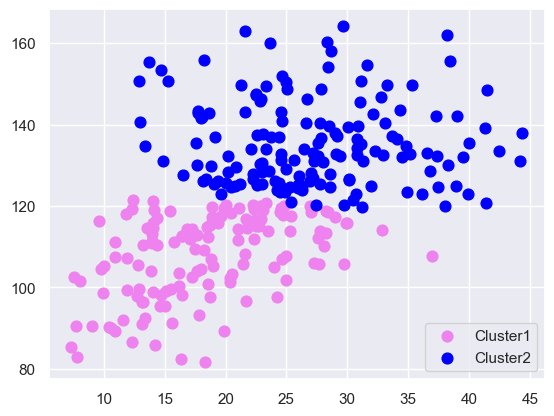

In [ ]:
kmeans = KMeans(n_init = 20, n_clusters = 2)
y_kmeans = kmeans.fit_predict(X)
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 60, c = 'violet', label = 'Cluster1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 60, c = 'blue', label = 'Cluster2')
plt.legend()

plt.show()

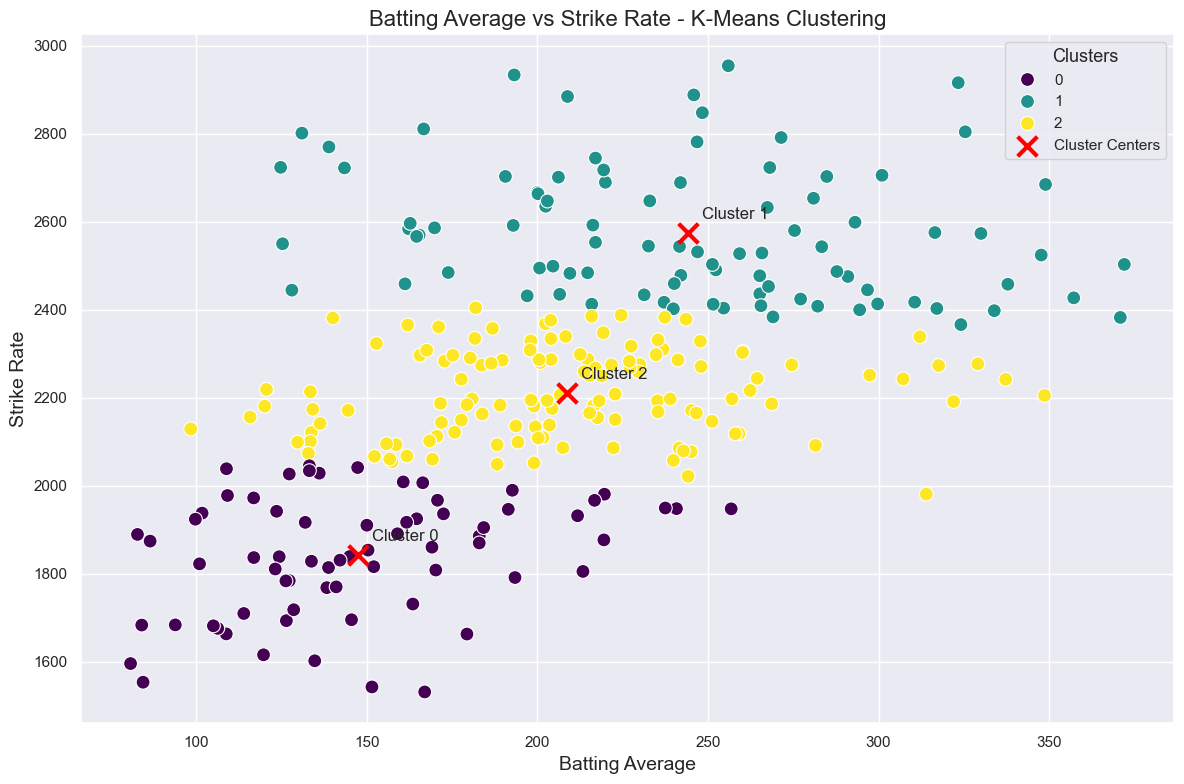

In [ ]:
# Perform K-Means Clustering
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# Create dataframe with original features and cluster labels
merged_stats = pd.DataFrame(scaler.inverse_transform(X), columns=['batting_avg', 'strike_rate'])
merged_stats['Cluster'] = cluster_labels

# Create a scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=merged_stats, 
    x='batting_avg', 
    y='strike_rate', 
    hue='Cluster',  # Use cluster labels for coloring
    palette='viridis', 
    s=100
)

# Plot cluster centers
centers = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=200, linewidths=3, label='Cluster Centers')

plt.title('Batting Average vs Strike Rate - K-Means Clustering', fontsize=16)
plt.xlabel('Batting Average', fontsize=14)
plt.ylabel('Strike Rate', fontsize=14)
plt.legend(title='Clusters', title_fontsize='13', fontsize='11')

# Annotate cluster centers
for i, center in enumerate(centers):
    plt.annotate(f'Cluster {i}', xy=(center[0], center[1]), 
                 xytext=(10, 10), textcoords='offset points', fontsize=12)

plt.tight_layout()
plt.show()